In [116]:
import joblib
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle
import toml
from tqdm import tqdm
import cv2
from copy import deepcopy

import sys
sys.path.append('/home/lea/trampo/SMPLAnthropometry')
sys.path.append('/home/lea/trampo')

from measure import MeasureBody
from measurement_definitions import STANDARD_LABELS
from data_format.save_keypoints import save_keypoints3d

from smplx import SMPL

from multiview_consistency import computeP, plot_view_consistency


In [117]:
betas_list, joints3d_list = [{}, {}, {}], [{}, {}, {}]

path = '/home/lea/trampo/4DHumans/outputs/results'
for file in os.listdir(path):
    results = joblib.load(os.path.join(path, file))
    id = int(file[5])-1

    """ for frame in results.values():
        if len(frame['tracked_ids']) >= 1:
            for t in frame['tracked_ids']:
                if t not in betas_list[id].keys():
                    betas_list[id].update({t : frame['smpl'][0]['betas']})
                else:
                    betas_list[id][t] = np.append(betas_list[id][t], frame['smpl'][0]['betas'])
                
                if t not in joints3d_list[id].keys():
                    joints3d_list[id].update({t: frame['3d_joints']})
                else:
                    joints3d_list[id][t] = np.append(joints3d_list[id][t], frame['3d_joints'])
    """

## Betas

In [118]:
joints3d_array = np.array(joints3d_list[0][1])
joints3d_array = joints3d_array.reshape(-1, 45, 3)
print(joints3d_array[0])

KeyError: 1

In [ ]:
for id, b in enumerate(betas_list):
    for t in b.keys():
        num_frames = len(b[t]) // 10
        print(id, t, num_frames)

0 1 4102
0 2 1478
0 3 2206
0 4 901
0 5 337
0 6 181
0 7 111
0 8 81
1 1 4885
1 2 851
1 4 463
1 7 143
1 3 1103
1 5 285
1 6 167
1 10 155
1 11 153
2 1 2878
2 14 726
2 2 1300


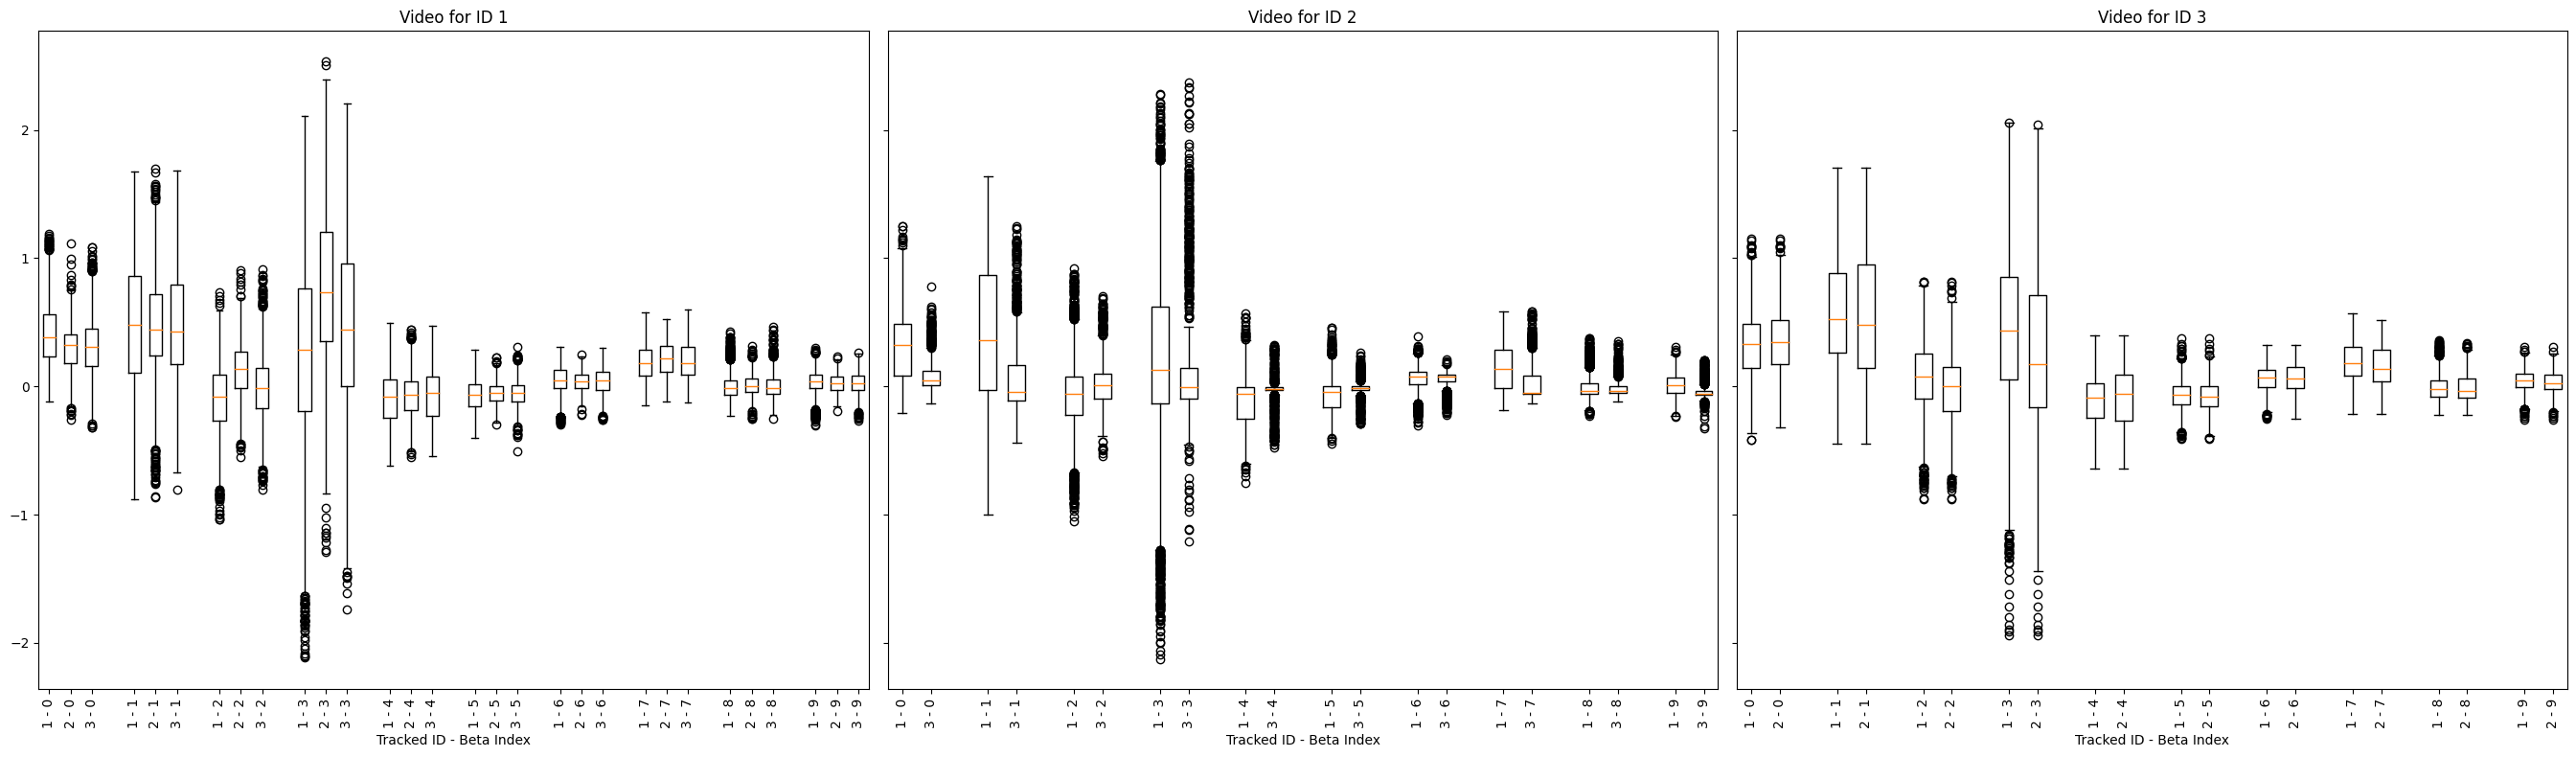

In [ ]:
min_frames = 1000  # set your desired threshold

num_ids = len(betas_list)
fig, axs = plt.subplots(1, num_ids, figsize=(9 * num_ids, 8), sharey=True)

for id in range(num_ids):
    ax = axs[id] if num_ids > 1 else axs
    beta_dict = betas_list[id]
    
    data_per_track = {}
    for t, flat_betas in beta_dict.items():
        betas = np.array(flat_betas).reshape(-1, 10)  # (N, 10)
        if betas.shape[0] >= min_frames:
            data_per_track[t] = betas

    if not data_per_track:
        ax.set_title(f"ID {id} (No tracks ≥ {min_frames} frames)")
        ax.axis('off')
        continue

    for beta_idx in range(10):
        beta_data = [data_per_track[t][:, beta_idx] for t in data_per_track]
        ax.boxplot(beta_data, 
                   positions=np.arange(len(beta_data)) + beta_idx * (len(data_per_track) + 1), 
                   widths=0.6)

    ax.set_title(f'Video for ID {id+1}')
    ax.set_xlabel('Tracked ID - Beta Index')

    xticks = []
    xticklabels = []
    for beta_idx in range(10):
        for i, t in enumerate(data_per_track.keys()):
            xticks.append(beta_idx * (len(data_per_track) + 1) + i)
            xticklabels.append(f'{t} - {beta_idx}')
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, rotation=90)

plt.tight_layout()
plt.show()


SMPL to anthropo - ID 1, Track 1:  12%|█▏        | 6/50 [00:08<01:00,  1.38s/it]


KeyboardInterrupt: 

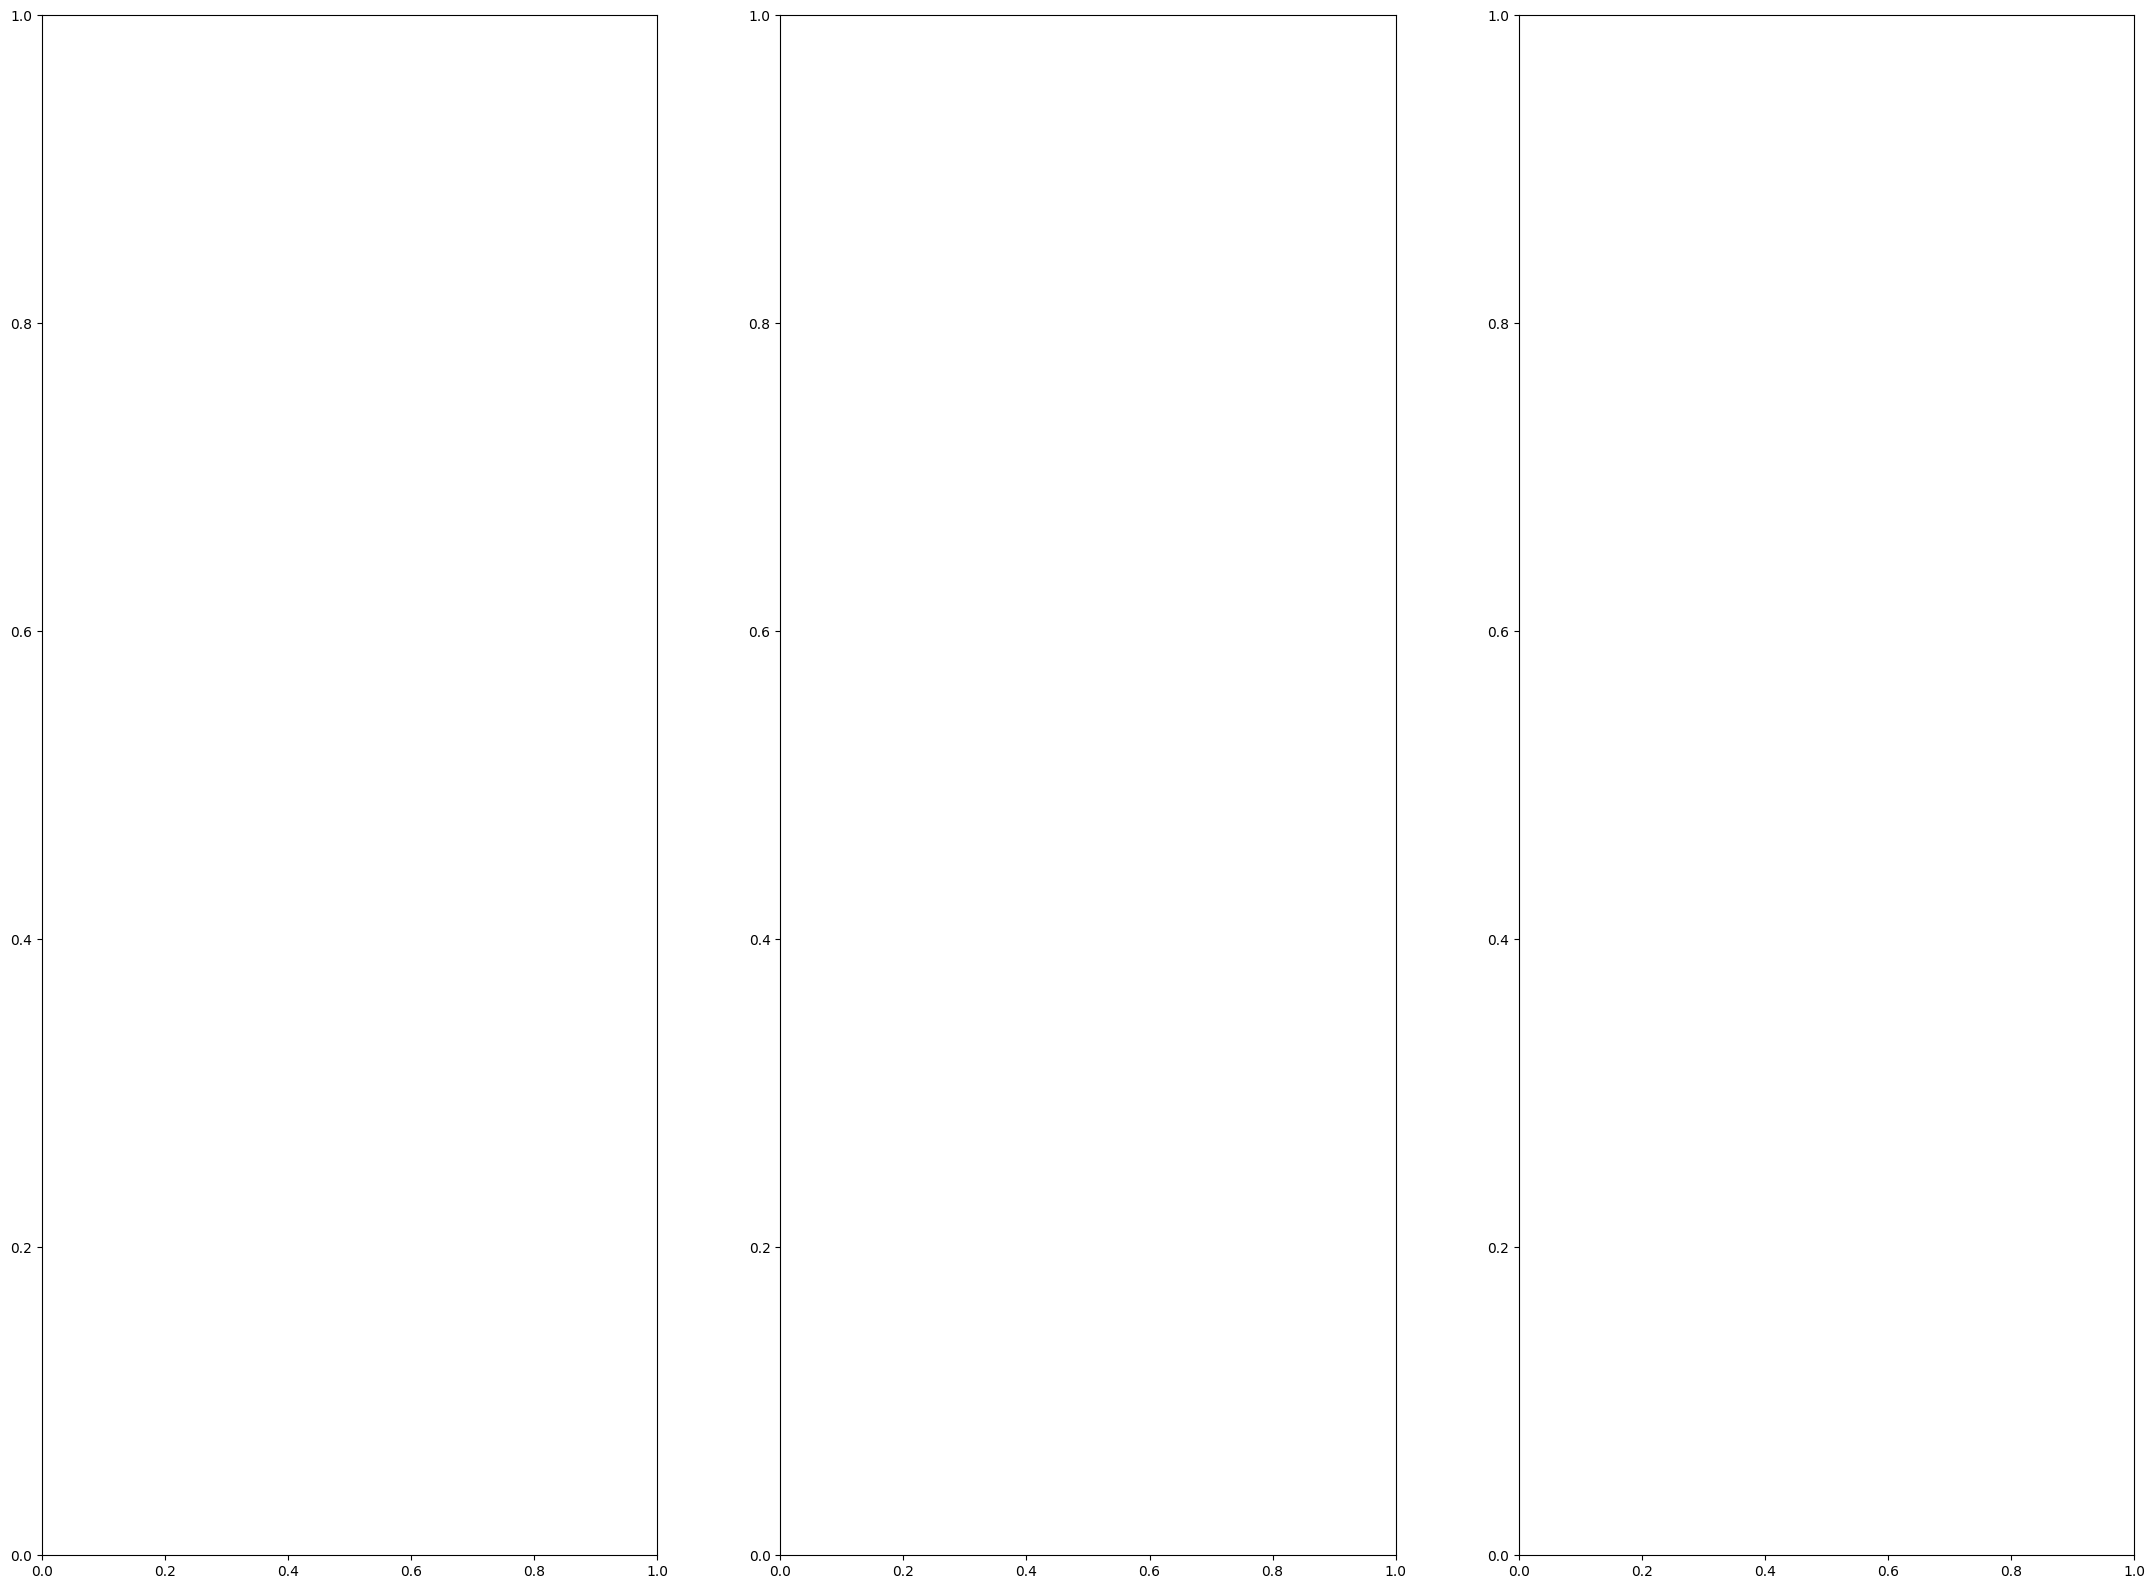

In [ ]:
min_frames = 1000  # Minimum number of frames to consider a track
num_ids = len(betas_list)
fig, axs = plt.subplots(1, num_ids, figsize=(9 * num_ids, 20))

for id in range(num_ids):
    ax = axs[id] if num_ids > 1 else axs
    beta_dict = betas_list[id]

    data_per_track = {}
    for t, flat_betas in beta_dict.items():
        betas = np.array(flat_betas).reshape(-1, 10)  # (N, 10)
        if betas.shape[0] >= min_frames:
            data_per_track[t] = betas

    if not data_per_track:
        ax.set_title(f"ID {id+1} (No tracks ≥ {min_frames} frames)")
        ax.axis('off')
        continue

    all_grouped = []
    track_labels = []

    for t_idx, (track_id, beta_data) in enumerate(data_per_track.items()):
        measurements = []
        for bd in tqdm(beta_data[:50], desc=f'SMPL to anthropo - ID {id+1}, Track {track_id}', total=50):
            bd = bd.reshape(1, 10)
            betas = torch.tensor(bd, dtype=torch.float32)

            measurer = MeasureBody('smpl')
            measurer.from_body_model(gender='neutral', shape=betas)

            measurement_names = measurer.all_possible_measurements
            measurer.measure(measurement_names)
            measurer.label_measurements(STANDARD_LABELS)

            measurements.append(measurer.measurements)

        # Group by measurement name
        grouped = {k: [d[k] for d in measurements] for k in measurements[0]}
        all_grouped.extend(grouped.values())
        track_labels.extend([f'{track_id} - {k}' for k in grouped.keys()])

    ax.boxplot(all_grouped)
    ax.set_title(f'Video for ID {id+1}')
    ax.set_xlabel('Measurement Type per Track')
    ax.set_xticks(range(1, len(track_labels) + 1))
    ax.set_xticklabels(track_labels, rotation=90)

ax.set_ylabel('Measurement Value')
plt.tight_layout()
plt.show()


### Même chose qu'avant mais on merge tous les tracked ids qui sont présents dans plus de N frams (après analyse visuelle, seul l'athlète est détecté mais mal tracké)

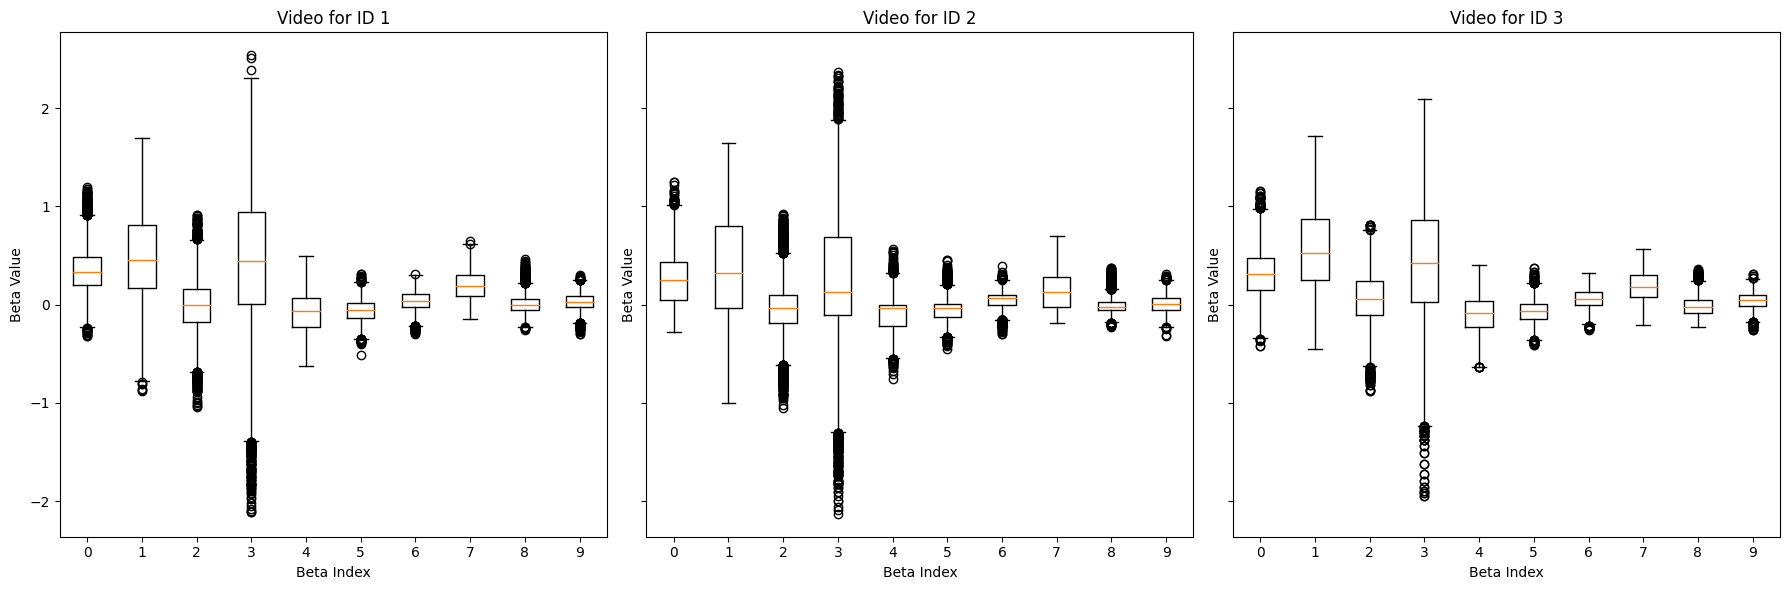

In [ ]:
min_frames = 120  # or whatever threshold you choose
merged_betas_list = []

for id in range(len(betas_list)):
    beta_dict = betas_list[id]
    merged_betas = []

    for t, flat_betas in beta_dict.items():
        betas = np.array(flat_betas).reshape(-1, 10)
        if betas.shape[0] >= min_frames:
            merged_betas.append(betas)

    if merged_betas:
        merged_betas = np.vstack(merged_betas)  # shape (N_total, 10)
    else:
        merged_betas = np.empty((0, 10))
        
    merged_betas_list.append(merged_betas)


fig, axs = plt.subplots(1, len(merged_betas_list), figsize=(6 * len(merged_betas_list), 6), sharey=True)

for id in range(len(merged_betas_list)):
    ax = axs[id] if len(merged_betas_list) > 1 else axs
    betas = merged_betas_list[id]

    if betas.shape[0] == 0:
        ax.set_title(f"ID {id} (No tracks ≥ {min_frames} frames)")
        ax.axis('off')
        continue

    # Prepare beta-wise data
    beta_data = [betas[:, i] for i in range(10)]
    ax.boxplot(beta_data, labels=[f'{i}' for i in range(10)])
    ax.set_title(f"Video for ID {id+1}")
    ax.set_xlabel('Beta Index')
    ax.set_ylabel('Beta Value')

plt.tight_layout()
plt.show()


### SMPL-Anthropometry avec tracked ids merged, sur tous les frames

(9205, 10)


SMPL to anthropo - ID 1: 100%|██████████| 1841/1841 [40:57<00:00,  1.34s/it]


(8205, 10)


SMPL to anthropo - ID 2: 100%|██████████| 1641/1641 [36:24<00:00,  1.33s/it]


(4904, 10)


SMPL to anthropo - ID 3: 100%|██████████| 981/981 [21:55<00:00,  1.34s/it]


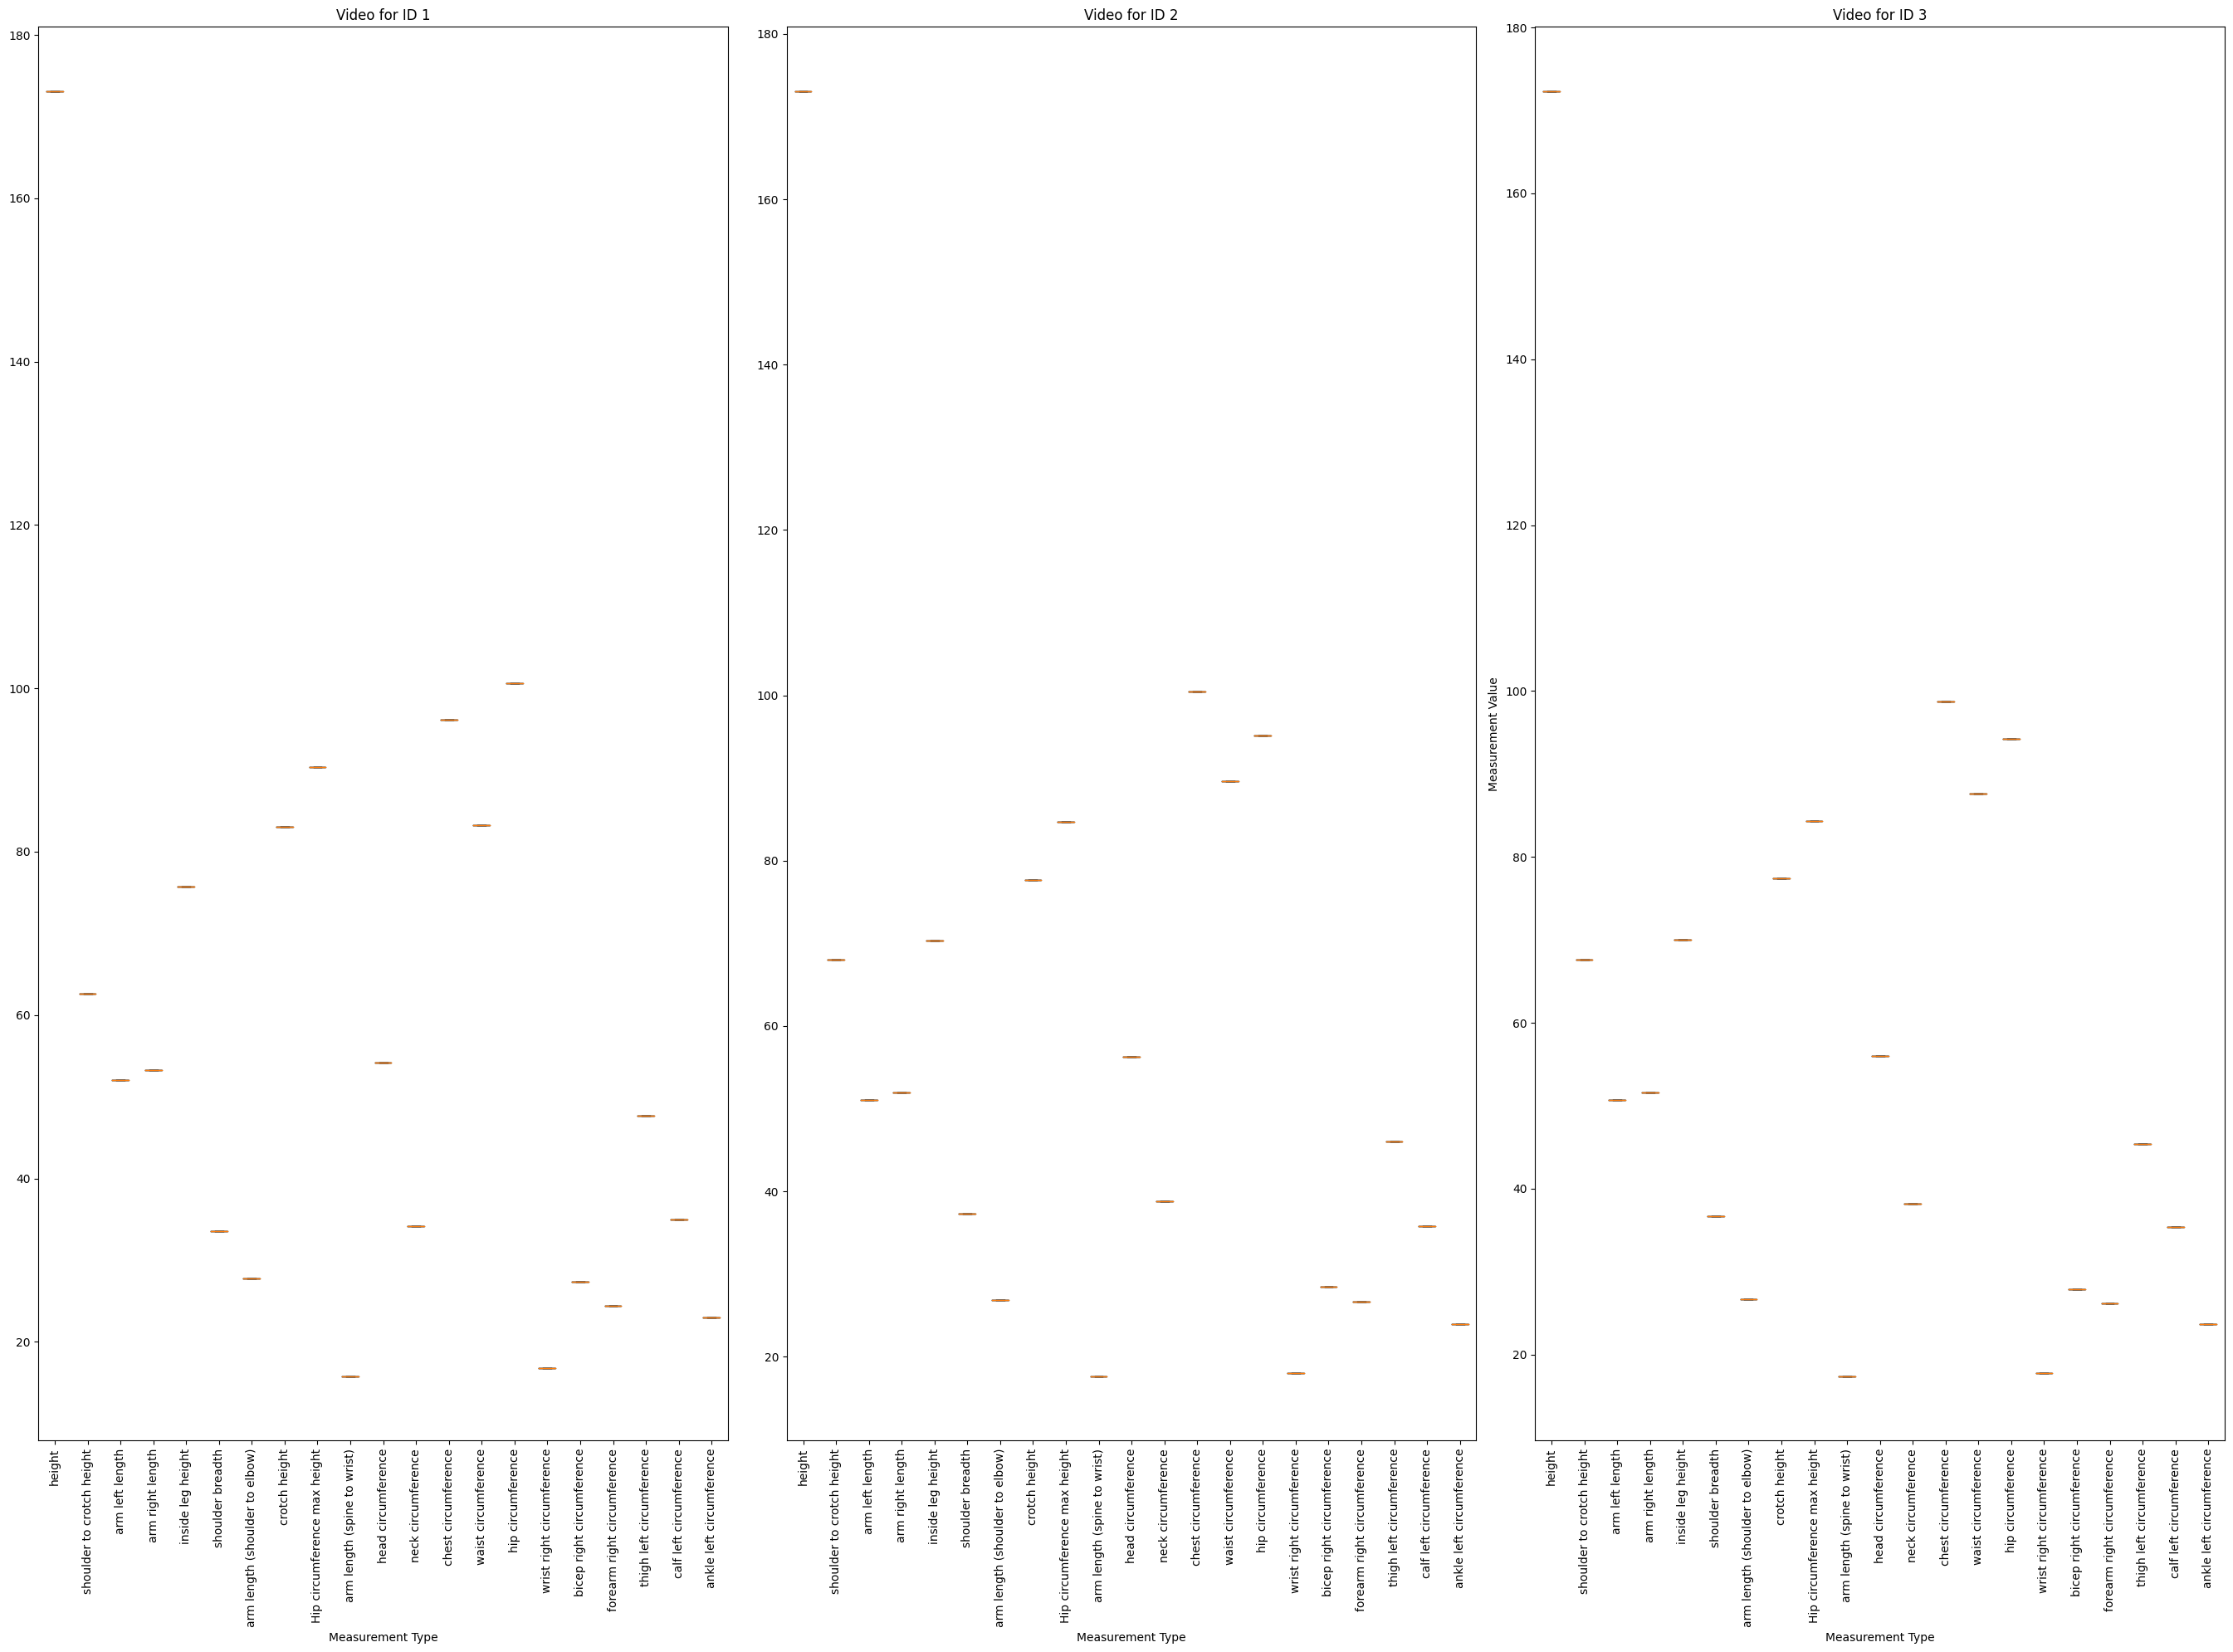

In [ ]:
num_ids = len(betas_list)
fig, axs = plt.subplots(1, num_ids, figsize=(9 * num_ids, 20))

for id in range(num_ids):
    ax = axs[id] if num_ids > 1 else axs
    beta_dict = betas_list[id]

    # Filter and merge all valid tracks for this ID
    merged_betas = []
    for t, flat_betas in beta_dict.items():
        betas = np.array(flat_betas).reshape(-1, 10)  # (N, 10)
        if betas.shape[0] >= min_frames:
            merged_betas.append(betas)

    if not merged_betas:
        ax.set_title(f"ID {id+1} (No tracks ≥ {min_frames} frames)")
        ax.axis('off')
        continue

    merged_betas = np.vstack(merged_betas)  # Combine into one array
    print(merged_betas.shape)
    measurements = []

    # Use only first 50 frames for measurement conversion (or adjust as needed)
    for bd in tqdm(range(0, len(merged_betas), 5), desc=f'SMPL to anthropo - ID {id+1}'):
        bd = merged_betas[i].reshape(1, 10)
        betas = torch.tensor(bd, dtype=torch.float32)

        measurer = MeasureBody('smpl')
        measurer.from_body_model(gender='neutral', shape=betas)

        measurement_names = measurer.all_possible_measurements
        measurer.measure(measurement_names)
        measurer.label_measurements(STANDARD_LABELS)

        measurements.append(measurer.measurements)

    # Group by measurement name
    grouped = {k: [d[k] for d in measurements] for k in measurements[0]}
    all_grouped = list(grouped.values())
    track_labels = list(grouped.keys())

    ax.boxplot(all_grouped)
    ax.set_title(f'Video for ID {id+1}')
    ax.set_xlabel('Measurement Type')
    ax.set_xticks(range(1, len(track_labels) + 1))
    ax.set_xticklabels(track_labels, rotation=90)

ax.set_ylabel('Measurement Value')
plt.tight_layout()
plt.show()

## Retrieve and save keypoints from SMPL output

In [119]:
def rotation_matrix_to_angle_axis(rotation_matrix):
    """
    Convert a batch of rotation matrices (N, 3, 3) to axis-angle (N, 3).
    """
    def _angle_axis_from_rotmat(R):
        cos_theta = (torch.diagonal(R, dim1=-2, dim2=-1).sum(-1) - 1) / 2
        cos_theta = torch.clamp(cos_theta, -1.0, 1.0)
        theta = torch.acos(cos_theta)

        rx = R[..., 2, 1] - R[..., 1, 2]
        ry = R[..., 0, 2] - R[..., 2, 0]
        rz = R[..., 1, 0] - R[..., 0, 1]
        axis = torch.stack([rx, ry, rz], dim=-1)

        axis = axis / (2 * torch.sin(theta).unsqueeze(-1) + 1e-8)
        axis_angle = axis * theta.unsqueeze(-1)

        axis_angle[torch.isnan(axis_angle)] = 0.0
        return axis_angle

    return _angle_axis_from_rotmat(rotation_matrix)

### Save SMPL 3D keypoints

In [120]:
model = SMPL(model_path='/home/lea/trampo/SMPLAnthropometry/data/smpl', gender='neutral', batch_size=1)

J_regressor = np.load('/home/lea/trampo/SMPLAnthropometry/J_regressor_coco.npy')  # shape: (17, 6890)
J_regressor = torch.tensor(J_regressor, dtype=torch.float32)

path = '/home/lea/trampo/4DHumans/outputs/results'
print(os.listdir(path))

for file in sorted(os.listdir(path)):
    all_keypoints = {}
    keypoint_pkl_path = None

    results = joblib.load(os.path.join(path, file))

    # Output setup
    json_output_dir = os.path.join('SMPL_keypoints', file.replace('demo_', '').split('.')[0] + '_json')
    pkl_output_dir = 'SMPL_keypoints'

    # Loop on all frames
    for frame in results: #['outputs//_DEMO/1_partie_0429-Camera1_M11139/img/000032.jpg']
        frame_res = results[frame]
        if len(frame_res['smpl']) == 0:
            continue

        keypoints = []
        keypoints_per_frame = []
        # Loop on detected ids
        for i, output in enumerate(frame_res['smpl']):
            try:
                id = frame_res['tracked_ids'][i]
            except IndexError:
                id = -1
            
            # Keypoints from SMPL
            your_10_betas = output['betas']
            betas_np = np.array(your_10_betas)

            your_global_orient = output['global_orient']
            your_body_pose = output['body_pose']
            your_transl = frame_res['pose'][i][-3:]

            body_pose_rotmats = torch.tensor(your_body_pose, dtype=torch.float32)  # ensure it's tensor
            # Convert (23, 3, 3) → (23, 3)
            body_pose_aa = rotation_matrix_to_angle_axis(body_pose_rotmats)

            # Handle potential NaNs due to numerical instability
            body_pose_aa[torch.isnan(body_pose_aa)] = 0.0
            body_pose_final = body_pose_aa.reshape(1, 69)

            global_orient_aa = rotation_matrix_to_angle_axis(torch.tensor(your_global_orient))  # (1, 3, 3) → (1, 3)
            #global_orient_aa = global_orient_aa.view(1, 3)

            betas = torch.tensor([betas_np], dtype=torch.float32)
            body_pose = torch.tensor([your_body_pose], dtype=torch.float32)
            global_orient = torch.tensor([your_global_orient], dtype=torch.float32)
            transl = torch.tensor([your_transl], dtype=torch.float32)

            output = model(
                betas=betas,                      # (1, 10)
                body_pose=body_pose_final,        # (1, 69)
                global_orient=global_orient_aa,   # (1, 3)
                transl=transl,
                return_verts=True)

            vertices = output.vertices  # (1, 6890, 3)

            keypoints_coco = torch.matmul(J_regressor, vertices[0])  # shape: (17, 3)
            keypoints_arr = keypoints_coco.detach().numpy()

            #print('SMPL', keypoints_arr, '\n')

            # Keypoints from Joints3D
            keypoints_3d = np.array(frame_res['3d_joints'][i])  # (49, 3)

            #print('Joints', keypoints_3d, '\n')
        
            keypoints.append((i, keypoints_3d.reshape(45,3)))

            keypoints_per_frame.append({"id": id,
                                        "keypoints": keypoints_3d.reshape(45,3).tolist()})

        image_file = frame.split('/')[-3]
        frame_idx = frame.split('/')[-1].split('.')[0]

        all_keypoints[frame_idx] = keypoints_per_frame

        json_file_path = os.path.join(json_output_dir, f"{os.path.splitext(os.path.basename(image_file))[0]}_{frame_idx}.json")
        keypoint_pkl_path = os.path.join(pkl_output_dir, f"{os.path.splitext(os.path.basename(image_file))[0]}.pkl")

        save_keypoints3d(json_file_path, keypoints)

    # Save all keypoints as .pkl
    if not os.path.isdir(pkl_output_dir): os.makedirs(pkl_output_dir)
    if keypoint_pkl_path is not None:
        with open(keypoint_pkl_path, 'wb') as f:
            pickle.dump(all_keypoints, f)

['demo_1_partie_0429_021-Camera1_M11139.pkl', 'demo_1_partie_0429_005-Camera6_M11461.pkl', 'demo_1_partie_0429_009-Camera3_M11141.pkl', 'demo_1_partie_0429_021-Camera8_M11463.pkl', 'demo_1_partie_0429_019-Camera6_M11461.pkl', 'demo_1_partie_0429_004-Camera4_M11458.pkl', 'demo_1_partie_0429_023-Camera2_M11140.pkl', 'demo_1_partie_0429_004-Camera1_M11139.pkl', 'demo_1_partie_0429_008-Camera6_M11461.pkl', 'demo_1_partie_0429_004-Camera7_M11462.pkl', 'demo_2_partie_0429-Camera7_M11462.pkl', 'demo_1_partie_0429_011-Camera4_M11458.pkl', 'demo_1_partie_0429_024-Camera4_M11458.pkl', 'demo_1_partie_0429_015-Camera4_M11458.pkl', 'demo_3_partie_0429_001-Camera2_M11140.pkl', 'demo_1_partie_0429_001-Camera6_M11461.pkl', 'demo_1_partie_0429_000-Camera4_M11458.pkl', 'demo_1_partie_0429_017-Camera2_M11140.pkl', 'demo_2_partie_0429_000-Camera4_M11458.pkl', 'demo_1_partie_0429_023-Camera5_M11459.pkl', 'demo_1_partie_0429_017-Camera8_M11463.pkl', 'demo_1_partie_0429_006-Camera5_M11459.pkl', 'demo_2_parti

/tmp/ipykernel_187377/826194801.py:53: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1724571756729/work/torch/csrc/utils/tensor_new.cpp:278.)
  betas = torch.tensor([betas_np], dtype=torch.float32)


KeyboardInterrupt: 

### Save 2D joints

In [121]:
def project(joints_3d, cam_trans, size, scale=1):
    f = 5000

    K = np.array([[f/256, 0, 0],
                [0, f/256, 0],
                [0, 0, 1]])
    R = np.eye(3)

    points = joints_3d + cam_trans # (4,3)

    proj = (K @ R @ points.T).T # (4,3)
    proj_norm = proj[:,:2] / proj[:,2].reshape(-1,1)
    proj_im = proj_norm * max(size) * scale
    proj_im += np.array(size[::-1])/2
    return proj_im

In [ ]:
path = '/home/lea/trampo/4DHumans/outputs/results'
print(os.listdir(path))

for file in sorted(os.listdir(path)):
    all_keypoints = {}
    keypoint_pkl_path = None

    results = joblib.load(os.path.join(path, file))

    # Output setup
    json_output_dir = os.path.join('results/SMPL_keypoints', file.replace('demo_', '').split('.')[0] + '_json')
    pkl_output_dir = 'results/SMPL_keypoints'

    # Loop on all frames
    for frame in results: #['outputs//_DEMO/1_partie_0429-Camera1_M11139/img/000032.jpg']
        frame_res = results[frame]
        if len(frame_res['smpl']) == 0:
            continue

        keypoints = []
        keypoints_per_frame = []
        # Loop on detected ids
        for i, output in enumerate(frame_res['smpl']):
            try:
                id = frame_res['tracked_ids'][i]
            except IndexError:
                id = -1
            
            bbox = frame_res['bbox'][i]
            conf = frame_res['conf'][i]
            conf = np.ones((45,1)) * conf

            size = frame_res['size'][i]
            cam_trans = frame_res['camera'][i]
            orient = frame_res['smpl'][i]['global_orient']
            T_cam = np.eye(4)
            T_cam[0:3, 0:3] = orient

            joints_3d = frame_res['3d_joints'][i]
            pts2d = project(joints_3d, cam_trans, size)

            keypoints = np.hstack((pts2d, conf))
        
            pts_orient = np.linalg.inv(T_cam) @ np.vstack((joints_3d.T * 1000, np.ones((1, 45))))
            pts_orient = pts_orient.T[:,0:3]

            keypoints_per_frame.append({"id": id,
                                        "bbox": bbox,
                                        "keypoints_2d": keypoints,
                                        "keypoints_3d": pts_orient})

        image_file = frame.split('/')[-3]
        frame_idx = frame.split('/')[-1].split('.')[0]

        all_keypoints[frame_idx] = keypoints_per_frame

        json_file_path = os.path.join(json_output_dir, f"{os.path.splitext(os.path.basename(image_file))[0]}_{frame_idx}.json")
        keypoint_pkl_path = os.path.join(pkl_output_dir, f"{os.path.splitext(os.path.basename(image_file))[0]}.pkl")

    # Save all keypoints as .pkl
    if not os.path.isdir(pkl_output_dir): os.makedirs(pkl_output_dir)
    if keypoint_pkl_path is not None: # and f"{os.path.splitext(os.path.basename(image_file))[0]}.pkl" not in os.listdir(pkl_output_dir):
        with open(keypoint_pkl_path, 'wb') as f:
            pickle.dump(all_keypoints, f)
    else:
        print('Invalid path or files already exist')

['demo_1_partie_0429_021-Camera1_M11139.pkl', 'demo_1_partie_0429_005-Camera6_M11461.pkl', 'demo_1_partie_0429_009-Camera3_M11141.pkl', 'demo_1_partie_0429_021-Camera8_M11463.pkl', 'demo_1_partie_0429_019-Camera6_M11461.pkl', 'demo_1_partie_0429_004-Camera4_M11458.pkl', 'demo_1_partie_0429_023-Camera2_M11140.pkl', 'demo_1_partie_0429_004-Camera1_M11139.pkl', 'demo_1_partie_0429_008-Camera6_M11461.pkl', 'demo_1_partie_0429_004-Camera7_M11462.pkl', 'demo_2_partie_0429-Camera7_M11462.pkl', 'demo_1_partie_0429_011-Camera4_M11458.pkl', 'demo_1_partie_0429_024-Camera4_M11458.pkl', 'demo_1_partie_0429_015-Camera4_M11458.pkl', 'demo_3_partie_0429_001-Camera2_M11140.pkl', 'demo_1_partie_0429_001-Camera6_M11461.pkl', 'demo_1_partie_0429_000-Camera4_M11458.pkl', 'demo_1_partie_0429_017-Camera2_M11140.pkl', 'demo_2_partie_0429_000-Camera4_M11458.pkl', 'demo_1_partie_0429_023-Camera5_M11459.pkl', 'demo_1_partie_0429_017-Camera8_M11463.pkl', 'demo_1_partie_0429_006-Camera5_M11459.pkl', 'demo_2_parti

In [122]:
def draw_skeleton(points_2d, color, ax, label=None, N=45):
    if N == 45:
        skeleton = [
            (16, 15),
            (0, 15),
            (0, 16),
            (0, 42),
            (0, 40),
            (40, 41),
            (41, 39),
            (40, 33),
            (33, 32),
            (32, 31),
            (40, 34),
            (34, 35),
            (35, 36),
            (39, 9),
            (9, 10),
            (10, 11),
            (39, 12),
            (12, 13),
            (13, 14)]
    elif N == 17:
        skeleton = [
            (5, 6),  # épaule gauche - coude gauche
            (5, 7),  # coude gauche - poignet gauche
            (7, 9),
            (6, 8),  # épaule droite - coude droit
            (8, 10), # coude droit - poignet droit
            (6, 12), # épaule gauche - hanche gauche
            (12, 14),# hanche gauche - hanche droite
            (14, 16),# hanche gauche - genou gauche
            (5, 11),
            (11, 13),# genou gauche - cheville gauche
            (13, 15),# hanche droite - genou droit
            (11, 12)]

    for i, j in skeleton:
        xline = [points_2d[i][0], points_2d[j][0]]
        yline = [points_2d[i][1], points_2d[j][1]]
        if points_2d[i].shape[-1] == 3:
            zline = [points_2d[i][2], points_2d[j][2]]
            ax.plot(xline, yline, zline, color=color)
        else:
            ax.plot(xline, yline, color=color)
    return

def draw_camera(ax, T_world_cam, color='r', scale=500):
    origin = T_world_cam[:3, 3]
    x_axis = T_world_cam[:3, 0] * scale + origin
    y_axis = T_world_cam[:3, 1] * scale + origin
    z_axis = T_world_cam[:3, 2] * scale + origin
    ax.plot([origin[0], x_axis[0]], [origin[1], x_axis[1]], [origin[2], x_axis[2]], color='r')
    ax.plot([origin[0], y_axis[0]], [origin[1], y_axis[1]], [origin[2], y_axis[2]], color='g')
    ax.plot([origin[0], z_axis[0]], [origin[1], z_axis[1]], [origin[2], z_axis[2]], color='b')
    return

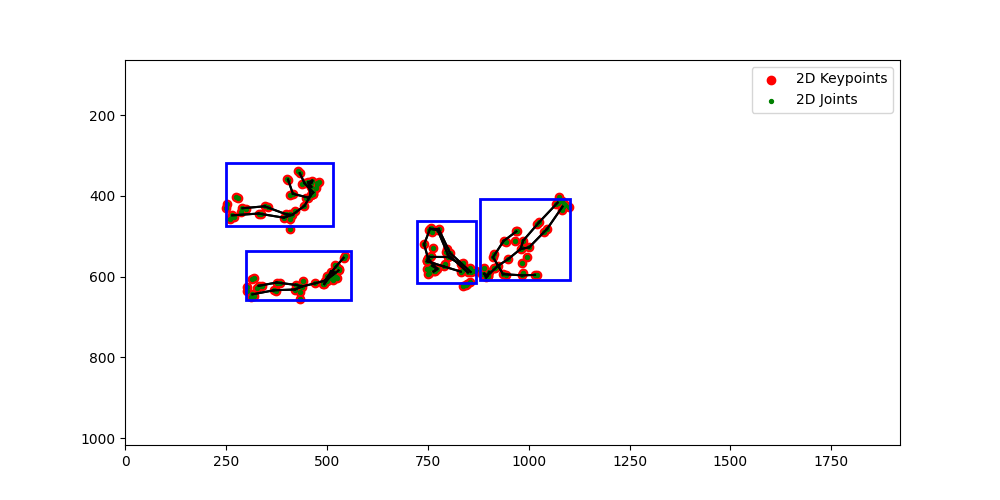

In [123]:
P_all, Kh = computeP('/home/lea/trampo/Pose2Sim/Calibration/Calib.toml')

model = SMPL(model_path='/home/lea/trampo/SMPLAnthropometry/data/smpl', gender='neutral', batch_size=1)

J_regressor = np.load('/home/lea/trampo/SMPLAnthropometry/J_regressor_coco.npy')  # shape: (17, 6890)
J_regressor = torch.tensor(J_regressor, dtype=torch.float32)

def extract_keypoints_smpl(frame_res, i, model, J_regressor):
    output = frame_res['smpl'][i]
    your_10_betas = output['betas']
    betas_np = np.array(your_10_betas)
    betas = torch.tensor([betas_np], dtype=torch.float32)

    your_global_orient = output['global_orient']
    global_orient_aa = rotation_matrix_to_angle_axis(torch.tensor(your_global_orient))  # (1, 3, 3) → (1, 3)

    your_body_pose = output['body_pose']
    body_pose_np = np.array(your_body_pose)
    body_pose_rotmats = torch.tensor(body_pose_np, dtype=torch.float32)  # ensure it's tensor
    # Convert (23, 3, 3) → (23, 3)
    body_pose_aa = rotation_matrix_to_angle_axis(body_pose_rotmats)

    # Handle potential NaNs due to numerical instability
    body_pose_aa[torch.isnan(body_pose_aa)] = 0.0
    body_pose_final = body_pose_aa.reshape(1, 69)
    
    your_transl = frame_res['pose'][i][-3:]
    transl = torch.tensor([your_transl], dtype=torch.float32)

    out = model(
        betas=betas,                      # (1, 10)
        body_pose=body_pose_final,        # (1, 69)
        global_orient=global_orient_aa,   # (1, 3)
        return_verts=True)

    vertices = out.vertices  # (1, 6890, 3)

    keypoints_coco = torch.matmul(J_regressor, vertices[0])  # shape: (17, 3)
    keypoints_arr = keypoints_coco.detach().numpy()

    return keypoints_arr

cam_idx = 1
cameras = ['M11139', 'M11140', 'M11141', 'M11458', 'M11459', 'M11461', 'M11462', 'M11463']

filepath = f'/home/lea/trampo/4DHumans/outputs/results/demo_1_partie_0429-Camera{cam_idx+1}_{cameras[cam_idx]}.pkl'
P = P_all[cam_idx]
K = Kh[cam_idx]
results = joblib.load(filepath)

# Plot
fig, ax = plt.subplots(figsize=(10,5))

# Loop on all frames
for frame in results: #['outputs//_DEMO/1_partie_0429-Camera1_M11139/img/000032.jpg']
    
    frame_res = results[frame]
    frame_idx = int(frame_res['time'])

    # Loop on detected ids
    for i, id in enumerate(frame_res['tracked_ids']):
        #print('id:', id)
        size = frame_res['size'][i]
        scale = frame_res['scale'][i]
        cam_trans = frame_res['camera'][i]
        center = frame_res['center'][i]
        bbox = frame_res['bbox'][i]
        xmin, ymin, width, height = bbox
        #print('BBOX:', bbox)

        """ # Keypoints from SMPL
        smpl_keypoints = extract_keypoints_smpl(frame_res, i, model, J_regressor)
        #smpl_keypoints = smpl_keypoints[:, [0,1,2]]
        transl = frame_res['camera_bbox'][i]
        smpl_proj = project(smpl_keypoints, cam_trans, size) """

        # 3D Joints projected
        joints_3d = frame_res['3d_joints'][i]
        pts2d = project(joints_3d, cam_trans, size)
        #print('Projected points')
        #print(pts2d)

        # 2D Joints
        joints_2d = frame_res['2d_joints'][i]
        joints_2d = np.array(joints_2d).reshape((45,2))

        joints_2d *= max(size)
        joints_2d = joints_2d - (0, 420)

        #print('Detected 2d points')
        #print(joints_2d)

        # Show points and bounding box
        if frame_idx % 300 == 0:
            # Add keypoints and bbox to plot
            ax.scatter(pts2d[:, 0], pts2d[:, 1], color='red', label='2D Keypoints')
            #for kp, pt in enumerate(pts2d):
            #    ax.text(pt[0], pt[1], kp, fontsize=6)
            draw_skeleton(pts2d, 'black', ax)
            ax.scatter(joints_2d[:,0], joints_2d[:,1], color='green', s=8, label='2D Joints')
            draw_skeleton(joints_2d, 'black', ax)
            #ax.scatter(smpl_proj[:,0], smpl_proj[:,1], color='lightblue', label='SMPL reprojection')
            #draw_skeleton(smpl_proj, 'lightblue', ax, N=17)
            #print(smpl_proj)
            bbox = plt.Rectangle((xmin, ymin), width, height,
                                linewidth=2, edgecolor='blue', facecolor='none')
            ax.add_patch(bbox)
            
        #break

ax.axis('equal')
ax.set_xlim(0,1920)
ax.set_ylim(0,1080)
ax.invert_yaxis()
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys())
plt.show()


### Find and reproject athlete

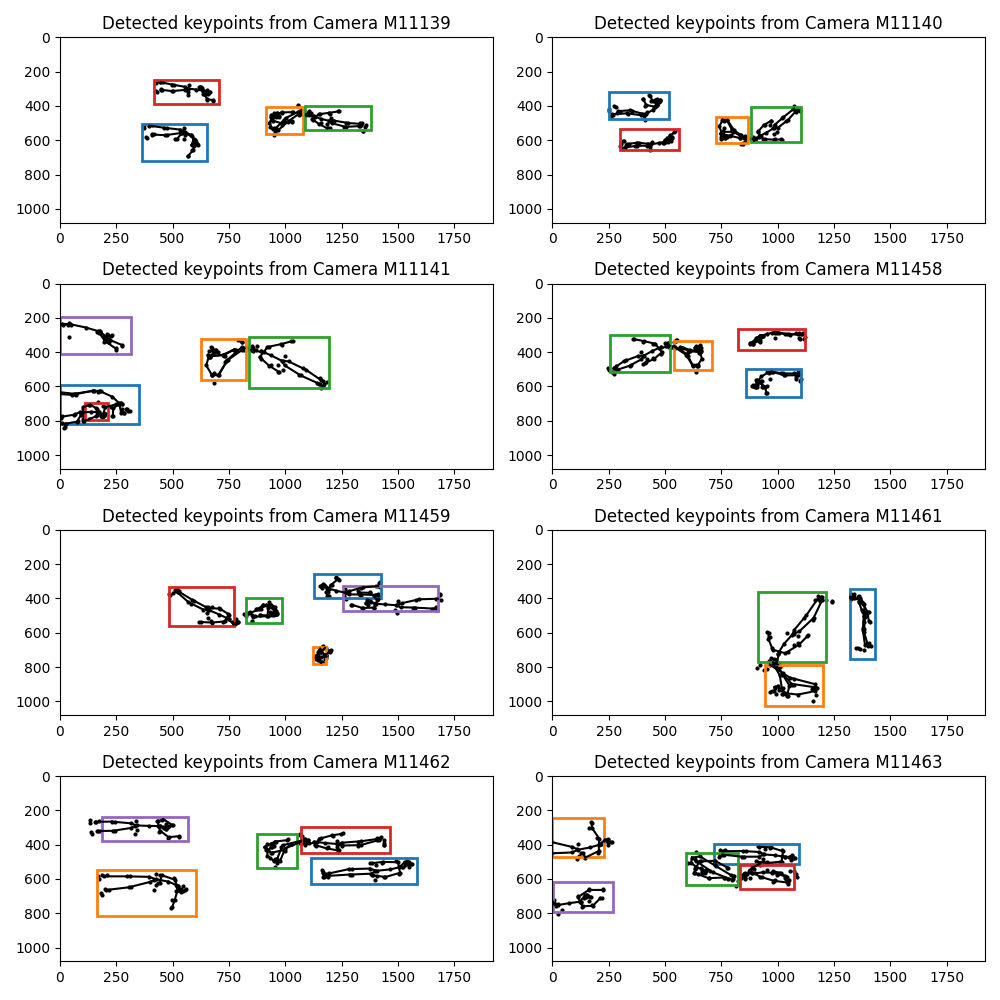

In [124]:
P_all, Kh = computeP('/home/lea/trampo/Pose2Sim/Calibration/Calib.toml')
cmap = plt.get_cmap('tab10')
colors = [cmap(i / 10) for i in range(8)]

cam_idx = 1
cameras = ['M11139', 'M11140', 'M11141', 'M11458', 'M11459', 'M11461', 'M11462', 'M11463']

# Plot
fig, axs = plt.subplots(4,2, figsize=(10,10))
axs = axs.flatten()

for cam_idx, ax in zip(range(8), axs):
    filepath = f'/home/lea/trampo/4DHumans/outputs/results/demo_1_partie_0429-Camera{cam_idx+1}_{cameras[cam_idx]}.pkl'
    P = P_all[cam_idx]
    K = Kh[cam_idx]
    results = joblib.load(filepath)

    # Loop on all frames
    c = 0
    for frame in results: #['outputs//_DEMO/1_partie_0429-Camera1_M11139/img/000032.jpg']
        
        frame_res = results[frame]
        frame_idx = int(frame_res['time'])

        # Loop on detected ids
        for i, id in enumerate(frame_res['tracked_ids']):
            #print('id:', id)
            size = frame_res['size'][i]
            cam_trans = frame_res['camera'][i]
            center = frame_res['center'][i]
            bbox = frame_res['bbox'][i]
            xmin, ymin, width, height = bbox

            # 3D Joints projected
            joints_3d = frame_res['3d_joints'][i]
            pts2d = project(joints_3d, cam_trans, size)

            # 2D Joints
            joints_2d = frame_res['2d_joints'][i]
            joints_2d = np.array(joints_2d).reshape((45,2))

            joints_2d *= max(size)
            joints_2d = joints_2d - (0, 420)

            # Show points and bounding box
            if frame_idx % 300 == 0:
                # Add keypoints and bbox to plot
                ax.scatter(pts2d[:, 0], pts2d[:, 1], color='black', s=4, label='2D Keypoints')
                draw_skeleton(pts2d, 'black', ax)
                #ax.scatter(joints_2d[:,0], joints_2d[:,1], color='green', s=8, label='2D Joints')
                #draw_skeleton(joints_2d, 'black', ax)

                bbox = plt.Rectangle((xmin, ymin), width, height,
                                     linewidth=2, edgecolor=colors[c], facecolor='none')
                ax.add_patch(bbox)
                c += 1
                
            #break

    ax.set_xlim(0,1920)
    ax.set_ylim(0,1080)
    ax.invert_yaxis()

    ax.set_title(f'Detected keypoints from Camera {cameras[cam_idx]}')

""" handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys()) """

plt.tight_layout()
plt.show()


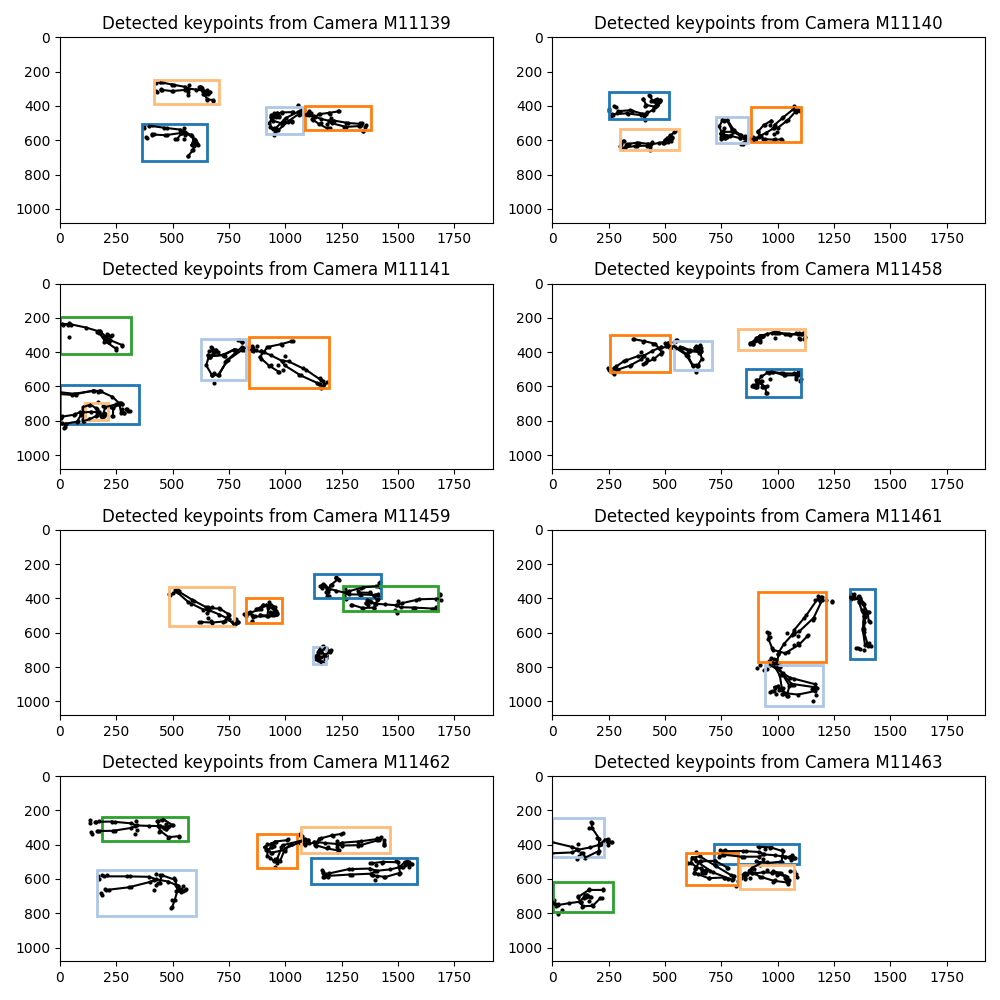

In [126]:
P_all, Kh = computeP('/home/lea/trampo/Pose2Sim/Calibration/Calib.toml')
cmap = plt.get_cmap('tab20')
colors = [cmap(i / 20) for i in range(20)]

cameras = ['M11139', 'M11140', 'M11141', 'M11458', 'M11459', 'M11461', 'M11462', 'M11463']

# Plot
fig, axs = plt.subplots(4,2, figsize=(10,10))
axs = axs.flatten()

pts = {c:{f:[] for f in range(0,2000)} for c in range(8)}

for cam_idx, ax in zip(range(8), axs):
    filepath = f'/home/lea/trampo/4DHumans/outputs/results/demo_1_partie_0429-Camera{cam_idx+1}_{cameras[cam_idx]}.pkl'
    P = P_all[cam_idx]
    K = Kh[cam_idx]
    results = joblib.load(filepath)

    # Loop on all frames
    c = 0
    for frame in results: #['outputs//_DEMO/1_partie_0429-Camera1_M11139/img/000032.jpg']
        frame_res = results[frame]
        frame_idx = int(frame_res['time'])

        # Loop on detected ids
        for i, id in enumerate(frame_res['tracked_ids']):
            #print('id:', id)
            size = frame_res['size'][i]
            cam_trans = frame_res['camera'][i]
            center = frame_res['center'][i]
            bbox = frame_res['bbox'][i]
            xmin, ymin, width, height = bbox

            # 2D Joints
            joints_2d = frame_res['2d_joints'][i]
            joints_2d = np.array(joints_2d).reshape((45,2))

            joints_2d *= max(size)
            joints_2d = joints_2d - (0, 420)

            pts[cam_idx][frame_idx].append(joints_2d)

            # Show points and bounding box
            if frame_idx % 300 == 0:
                # Add keypoints and bbox to plot
                ax.scatter(joints_2d[:,0], joints_2d[:,1], color='black', s=4, label='2D Joints')
                draw_skeleton(joints_2d, 'black', ax)

                bbox = plt.Rectangle((xmin, ymin), width, height,
                                     linewidth=2, edgecolor=colors[c], facecolor='none')
                ax.add_patch(bbox)
                c += 1

            #break

    ax.set_xlim(0,1920)
    ax.set_ylim(0,1080)
    ax.invert_yaxis()

    ax.set_title(f'Detected keypoints from Camera {cameras[cam_idx]}')

""" handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys()) """

plt.tight_layout()
plt.show()


In [127]:
pts_athlete = {c:{f:[] for f in range(0,2000)} for c in range(8)}

for c1 in range(8):
    for c2 in range(c1+1, 8):

        P1 = P_all[c1]
        P2 = P_all[c2]
        
        for frame_idx in (set(pts[c1]) & set(pts[c2])):
            
            error_min = 100

            """ if len(pts[c1][frame_idx]) > 1 or len(pts[c2][frame_idx]) > 1:
                print(len(pts[c1][frame_idx]), len(pts[c2][frame_idx])) """

            for points1 in pts[c1][frame_idx]:
                for points2 in pts[c2][frame_idx]:

                    if len(points1) > 0 and len(points2) > 0:

                        pts1 = np.asarray(points1).squeeze()
                        pts2 = np.asarray(points2).squeeze()

                        points_4d = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)
                        points_3d = (points_4d[:3] / points_4d[3]).T  # Nx3
                        points_3d_h = np.hstack((points_3d, np.ones((points_3d.shape[0], 1)))).T  # 4xN

                        pts1_reproj_h = P1 @ points_3d_h  # 3xN
                        pts1_reproj = (pts1_reproj_h[:2] / pts1_reproj_h[2]).T  # Nx2

                        pts2_reproj_h = P2 @ points_3d_h  # 3xN
                        pts2_reproj = (pts2_reproj_h[:2] / pts2_reproj_h[2]).T  # Nx2

                        error1 = np.linalg.norm(pts1 - pts1_reproj, axis=1)
                        error2 = np.linalg.norm(pts2 - pts2_reproj, axis=1)

                        if (error1 < error_min).all() and (error2 < error_min).all():
                            pts_athlete[c1][frame_idx] = pts1
                            pts_athlete[c2][frame_idx] = pts2
                            error_min = np.max([error1, error2])


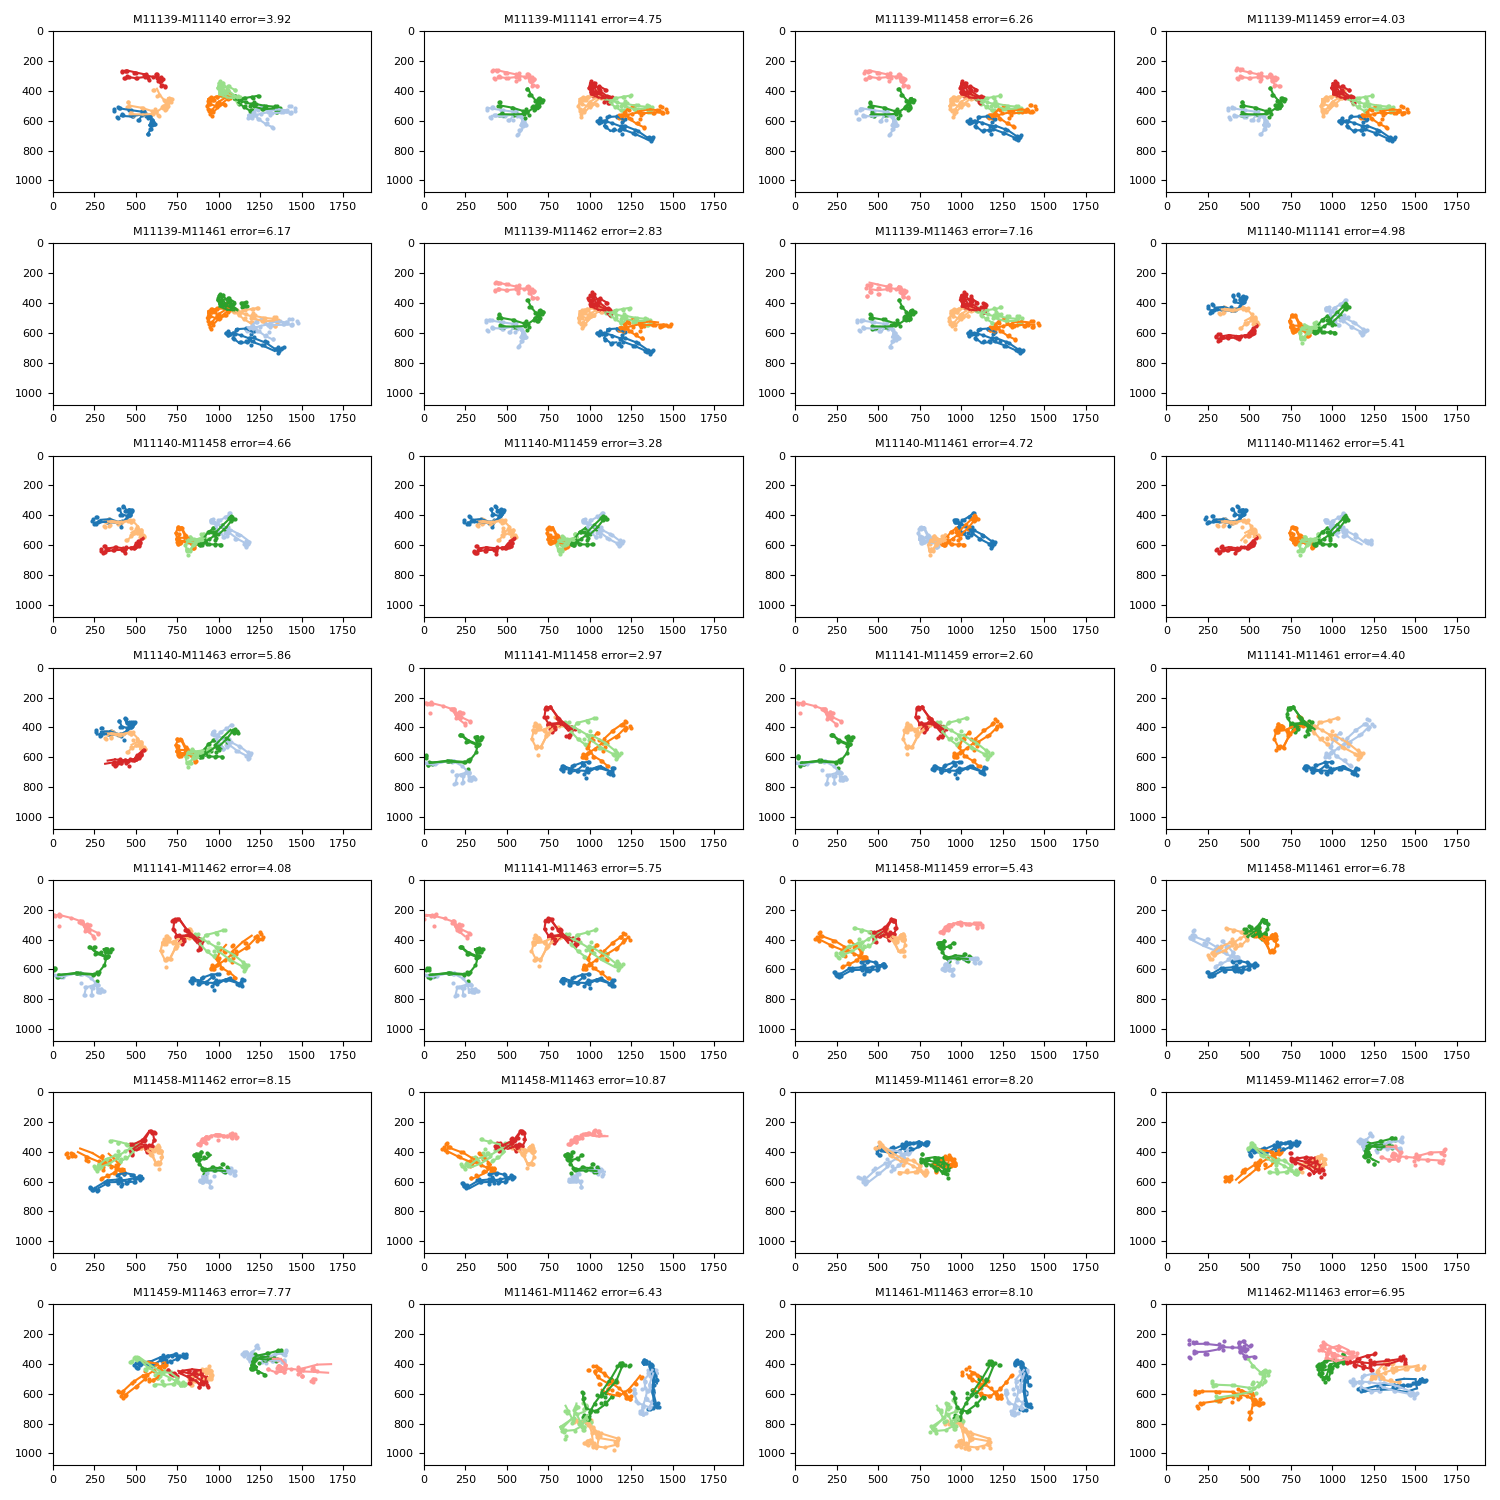

{'39-40': [4.422150818663836, 3.563746835203128, 6.463547118536659, 3.559158473038587, 3.6458412605101524, 3.8480262175000517, 2.6608974564696672, 2.2201392547197254, 2.3947018450877016, 2.6885546872311297, 3.948553109602539, 3.6205905810249766, 3.1916897460407605, 4.876460248047891, 4.733293406752681, 4.043775928513498, 3.235221427548616, 3.6322880738645495, 3.699384169424857, 4.156177294790863, 4.6813730863662135, 5.2588315317358685, 5.256684552753971, 5.6458456993602715, 4.137410641383246, 4.482647947781874, 4.604120924272854, 4.9710808836639835, 4.6247445582527495, 4.994341895130017, 6.740241770919119, 5.753972975149802, 4.7738525887732735, 4.104065264931614, 3.751262570078722, 3.299983082130099, 3.3728410408561516, 4.8522227929176625, 4.892658322419111, 4.62117673486158, 3.9089109543610756, 4.396529219993276, 3.6830840155440727, 4.129100381805191, 3.971501959104589, 3.175668989697979, 2.6167267067701894, 3.0111762399286146, 4.6090209967328875, 5.268817722431654, 4.2738086319804145

TypeError: plot_view_consistency() missing 1 required positional argument: 'input_data'

In [128]:
from copy import deepcopy

error_cam_1 = {f'{c1[-2:]}-{c2[-2:]}':[] for c1 in cameras for c2 in cameras if c2 > c1}
error_cam_2 = deepcopy(error_cam_1)

# Plot
fig, axs = plt.subplots(7,4, figsize=(15,15))
axs = axs.flatten()

ax_i = 0
for c1 in range(8):
    for c2 in range(c1+1, 8):

        ax = axs[ax_i]

        P1 = P_all[c1]
        P2 = P_all[c2]
        
        c = 0
        for frame_idx in (set(pts_athlete[c1]) & set(pts_athlete[c2])):
            pts1 = np.asarray(pts_athlete[c1][frame_idx]).squeeze()
            pts2 = np.asarray(pts_athlete[c2][frame_idx]).squeeze()

            if len(pts1) > 0 and len(pts2) > 0:

                points_4d = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)
                points_3d = (points_4d[:3] / points_4d[3]).T  # Nx3
                points_3d_h = np.hstack((points_3d, np.ones((points_3d.shape[0], 1)))).T  # 4xN

                pts1_reproj_h = P1 @ points_3d_h  # 3xN
                pts1_reproj = (pts1_reproj_h[:2] / pts1_reproj_h[2]).T  # Nx2

                pts2_reproj_h = P2 @ points_3d_h  # 3xN
                pts2_reproj = (pts2_reproj_h[:2] / pts2_reproj_h[2]).T  # Nx2

                error1 = np.linalg.norm(pts1 - pts1_reproj, axis=1)
                error2 = np.linalg.norm(pts2 - pts2_reproj, axis=1)
                error_cam_1[f'{cameras[c1][-2:]}-{cameras[c2][-2:]}'].append(np.mean(error1))
                error_cam_2[f'{cameras[c1][-2:]}-{cameras[c2][-2:]}'].append(np.mean(error2))

                # Show points and bounding box
                if frame_idx % 150 == 0:
                    # Add keypoints and bbox to plot
                    #ax.scatter(pts1[:,0], pts1[:,1], color='black', s=4, label='detected')
                    draw_skeleton(pts1, colors[c], ax)

                    ax.scatter(pts1_reproj[:,0], pts1_reproj[:,1], color=colors[c], s=4, label='projected')
                    #draw_skeleton(pts1_reproj, 'black', ax)

                    c += 1

                #break

        ax.set_xlim(0,1920)
        ax.set_ylim(0,1080)

        ax.tick_params(axis='x', labelsize=8)
        ax.tick_params(axis='y', labelsize=8)

        ax.invert_yaxis()

        ax.set_title(f"{cameras[c1]}-{cameras[c2]} error={np.median(error_cam_1[f'{cameras[c1][-2:]}-{cameras[c2][-2:]}']):.2f}", fontsize=8)
        ax_i += 1

plt.tight_layout()
plt.show()

print(error_cam_1, '\n', error_cam_2)

all_keys = set(error_cam_1) | set(error_cam_2)
error_cam_all = {k: error_cam_1.get(k, []) + error_cam_2.get(k, []) for k in all_keys}

from multiview_consistency import plot_view_consistency
plot_view_consistency(error_cam_all, no_outliers=True)

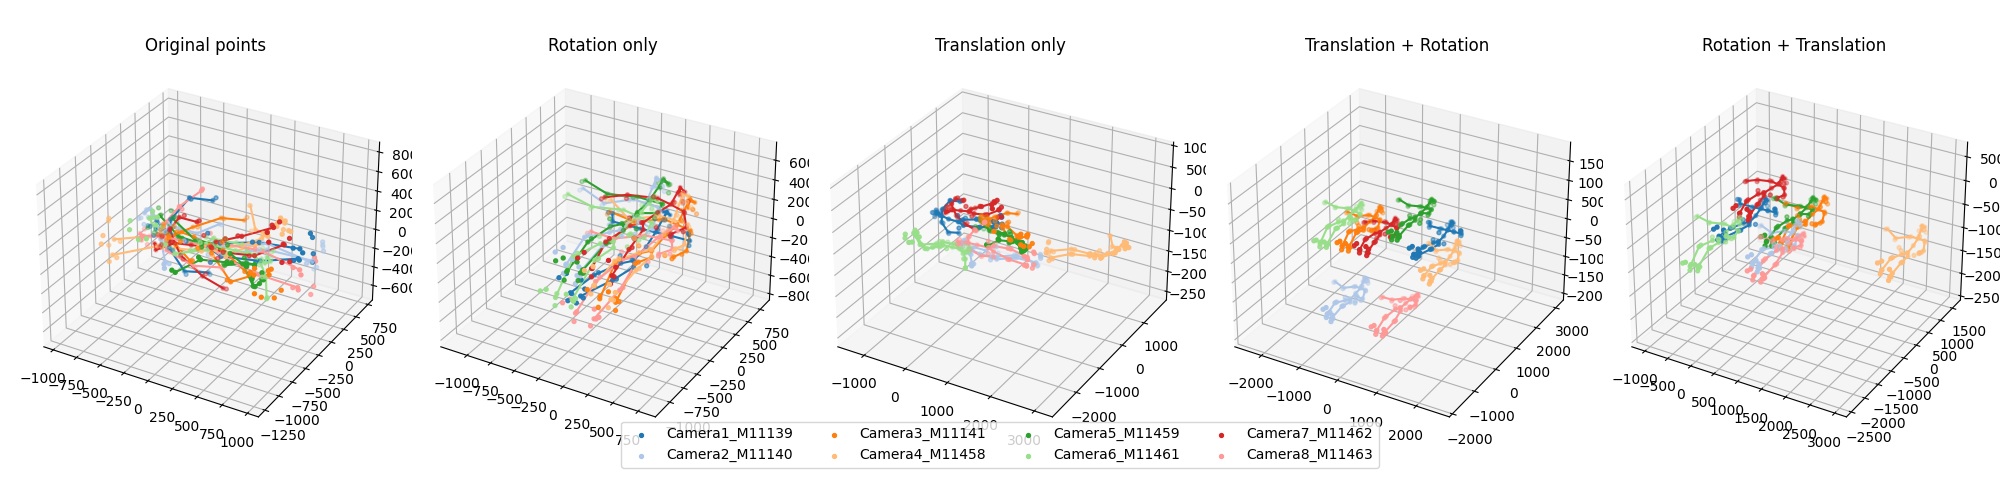

In [130]:
%matplotlib widget
cmap = plt.get_cmap('tab20')
colors = [cmap(i / 20) for i in range(20)]

P_all, Kh = computeP('/home/lea/trampo/Pose2Sim/Calibration/Calib.toml')
mat_transfo = np.load('/mnt/D494C4CF94C4B4F0/Trampoline_avril2025/Calib_trampo_avril2025/results_calib/calib_0429/WorldTCam_opt.npz')['arr_0']

f = 5000
K1 = np.array([[f/256, 0, 0],
                   [0, f/256, 0],
                   [0, 0, 1]])

cameras = ['Camera1_M11139', 'Camera2_M11140', 'Camera3_M11141', 'Camera4_M11458', 'Camera5_M11459', 'Camera6_M11461', 'Camera7_M11462', 'Camera8_M11463']
routine = '1_partie_0429_001'

# Plot
fig, axes = plt.subplots(1, 5, figsize=(20,5), subplot_kw={'projection': '3d'})
ax1, ax2, ax3, ax4, ax5 = axes[0], axes[1], axes[2], axes[3], axes[4]

for cam in cameras:
    cam_idx = cameras.index(cam)

    filepath = f'/home/lea/trampo/4DHumans/outputs/results/demo_{routine}-{cam}.pkl'
    P = P_all[cam_idx]
    K = Kh[cam_idx][:, 0:3]
    K2_inv = np.linalg.inv(K)

    T2 = mat_transfo[cam_idx]
    R2 = T2[0:3,0:3]
    t2 = T2[0:3,3].reshape((3,1))

    T2_inv = np.linalg.inv(T2)
    R2_inv = T2_inv[0:3, 0:3]
    t2_inv = T2_inv[0:3,3].reshape((3,1))

    results = joblib.load(filepath)

    frame_idx = 714
    
    frame = f'outputs//_DEMO/{routine}-{cam}/img/{frame_idx:06d}.jpg' #['outputs//_DEMO/1_partie_0429-Camera1_M11139/img/000032.jpg']
    frame_res = results[frame]

    # Loop on detected ids
    for i, id in enumerate(frame_res['tracked_ids']):
        size = frame_res['size'][i]
        scale = frame_res['scale'][i]

        #cam_trans = frame_res['camera'][i].reshape((3,)) 
        cam_trans = frame_res['pose'][i][-3:].reshape((3,)) * 1000
        orient = frame_res['smpl'][i]['global_orient']

        T_cam = np.eye(4)
        T_cam[0:3, 0:3] = orient

        # 3D Joints
        joints_3d = frame_res['3d_joints'][i] * 1000
        pts3d = joints_3d

        ax1.scatter(pts3d[:,0], pts3d[:,1], pts3d[:,2], color=colors[cam_idx], s=8)
        ax1.set_title('Original points')
        draw_skeleton(pts3d, colors[cam_idx], ax1)

        pts_orient = np.linalg.inv(T_cam) @ np.vstack((joints_3d.T, np.ones((1, 45))))
        pts_orient = pts_orient.T[:,0:3]
        ax2.scatter(pts_orient[:,0], pts_orient[:,1], pts_orient[:,2], color=colors[cam_idx], s=8)
        ax2.set_title('Rotation only')
        draw_skeleton(pts_orient, colors[cam_idx], ax2)

        pts_trans = joints_3d - cam_trans.reshape((1,3))

        ax3.scatter(pts_trans[:,0], pts_trans[:,1], pts_trans[:,2], color=colors[cam_idx], s=8, label=cam)
        ax3.set_title('Translation only')
        draw_skeleton(pts_trans, colors[cam_idx], ax3)

        pts_trans_rot = np.linalg.inv(T_cam) @ np.vstack((pts_trans.T, np.ones((1, 45))))
        pts_trans_rot = pts_trans_rot.T[:,0:3]
        ax4.scatter(pts_trans_rot[:,0], pts_trans_rot[:,1], pts_trans_rot[:,2], color=colors[cam_idx], s=8)
        ax4.set_title('Translation + Rotation')
        draw_skeleton(pts_trans_rot, colors[cam_idx], ax4)

        #T_cam[0:3, 3] = cam_trans
        pts_rot_trans = np.linalg.inv(T_cam) @ np.vstack((joints_3d.T, np.ones((1, 45))))
        pts_rot_trans = pts_rot_trans.T[:,0:3] - cam_trans
        ax5.scatter(pts_rot_trans[:,0], pts_rot_trans[:,1], pts_rot_trans[:,2], color=colors[cam_idx], s=8)
        ax5.set_title('Rotation + Translation')
        draw_skeleton(pts_rot_trans, colors[cam_idx], ax5)


#for i, T in enumerate(mat_transfo):
#    draw_camera(ax, T, color=colors[i % len(colors)])

for ax in axes:
    ax.axis('equal')

fig.legend(loc='lower center', ncol=4, bbox_to_anchor=(0.5, 0.05))
plt.subplots_adjust(bottom=0.2)
plt.tight_layout()
plt.show()


## Compare reference frames

### Change camera perspective

In [ ]:
def cam_crop2full(crop_cam, center, scale, full_img_shape, focal_length):
    """
    convert the camera parameters from the crop camera to the full camera
    :param crop_cam: shape=(N, 3) weak perspective camera in cropped img coordinates (s, tx, ty)
    :param center: shape=(N, 2) bbox coordinates (c_x, c_y)
    :param scale: shape=(N, 1) square bbox resolution  (b / 200)
    :param full_img_shape: shape=(N, 2) original image height and width
    :param focal_length: shape=(N,)
    :return:
    """
    img_h, img_w = full_img_shape[:, 0], full_img_shape[:, 1]
    cx, cy, b = center[:, 0], center[:, 1], scale * 200
    w_2, h_2 = img_w / 2., img_h / 2.
    bs = b * crop_cam[:, 0] + 1e-9
    tz = 2 * focal_length / bs
    tx = (2 * (cx - w_2) / bs) + crop_cam[:, 1]
    ty = (2 * (cy - h_2) / bs) + crop_cam[:, 2]
    full_cam = torch.stack([tx, ty, tz], dim=-1)
    return full_cam

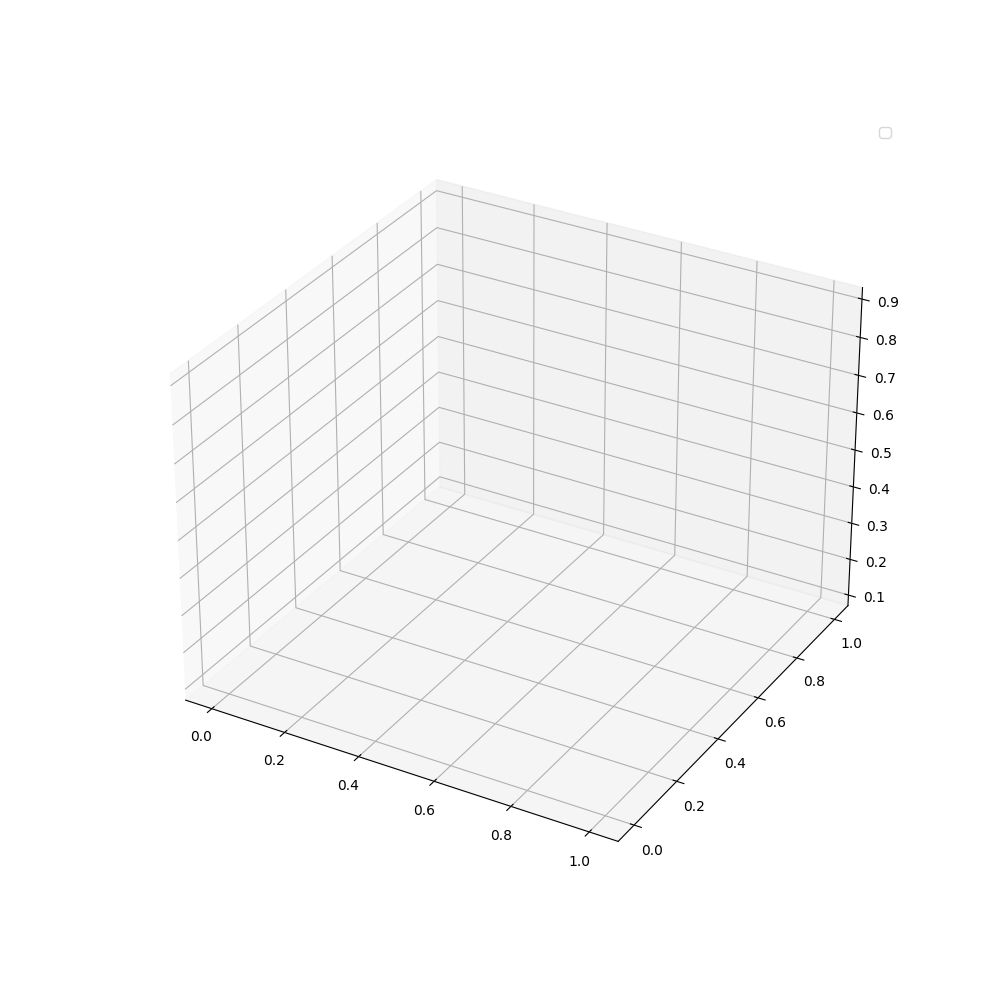

In [ ]:
%matplotlib widget
cmap = plt.get_cmap('tab10')
colors = [cmap(i / 10) for i in range(8)]

P_all, Kh = computeP('/home/lea/trampo/Pose2Sim/Calibration/Calib.toml')
mat_transfo = np.load('/mnt/D494C4CF94C4B4F0/Trampoline_avril2025/Calib_trampo_avril2025/results_calib/calib_0429/WorldTCam_opt.npz')['arr_0']

f = 5000
K1 = K = np.array([[f/256, 0, 0],
                   [0, f/256, 0],
                   [0, 0, 1]])

cameras = ['Camera1_M11139', 'Camera2_M11140', 'Camera3_M11141', 'Camera4_M11458', 'Camera5_M11459', 'Camera6_M11461', 'Camera7_M11462', 'Camera8_M11463']

# Plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

frame_idx = 230
routine = '1_partie_0429_000'

for cam_idx, cam in enumerate(cameras):
    cam_idx
    filepath = f'/home/lea/trampo/4DHumans/outputs/results/demo_{routine}-{cam}.pkl'
    P = P_all[cam_idx]
    K = Kh[cam_idx][:, 0:3]

    T2 = mat_transfo[cam_idx]
    R2 = T2[0:3,0:3]
    t2 = T2[0:3,3].reshape((3,1))

    T2_inv = np.linalg.inv(T2)
    R2_inv = T2_inv[0:3, 0:3]
    t2_inv = T2_inv[0:3,3].reshape((3,1))
    
    K2_inv = np.linalg.inv(K)

    try:
        results = joblib.load(filepath)
    except FileNotFoundError:
        continue

    frame = f'outputs//_DEMO/{routine}-{cam}/img/{frame_idx:06d}.jpg' #['outputs//_DEMO/1_partie_0429-Camera1_M11139/img/000032.jpg']

    frame_res = results[frame]
    break
    frame_idx = int(frame_res['time'])

    # Loop on detected ids
    for i, id in enumerate(frame_res['tracked_ids']):
        #print('id:', id)
        size = frame_res['size'][i]
        scale = frame_res['scale'][i]

        #cam_trans = frame_res['camera'][i].reshape((3,))
        cam_trans = frame_res['pose'][i][-3:].reshape((3,)) * 1000
        orient = frame_res['smpl'][i]['global_orient'].squeeze()

        T_cam = np.eye(4)
        T_cam[0:3, 0:3] = orient
        T_cam[0:3, 3] = cam_trans

        # 3D Joints
        joints_3d = frame_res['3d_joints'][i] * 1000 

        pts3d = joints_3d + (0, 0, 2000)

        #ax.scatter(pts3d[:,0], pts3d[:,1], pts3d[:,2], color=colors[cameras.index(cam)], s=8, label=cam)
        #draw_skeleton(pts3d, colors[cameras.index(cam)], ax)

        points = np.linalg.inv(T_cam) @ np.vstack((joints_3d.T, np.ones((1, 45))))

        points = np.linalg.inv(orient) @ joints_3d.T + cam_trans.reshape((3,1))
    
        #points = T2 @ np.vstack((pts3d.T + cam_trans, np.ones((1, 45))))
        #points = R2_inv @ (K2_inv @ K1 @ (joints_3d.T + cam_trans) + t2_inv)
        #points = K2_inv @ K1 @ (joints_3d + cam_trans)
        points = points.T[:,0:3]

        ax.scatter(points[:,0], points[:,1], points[:,2], color=colors[cameras.index(cam)], s=8, label=cam)
        draw_skeleton(points, colors[cameras.index(cam)], ax)

        #break

#for i, T in enumerate(mat_transfo):
#    draw_camera(ax, T, color=colors[i % len(colors)])

ax.axis('equal')

handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys())
plt.show()


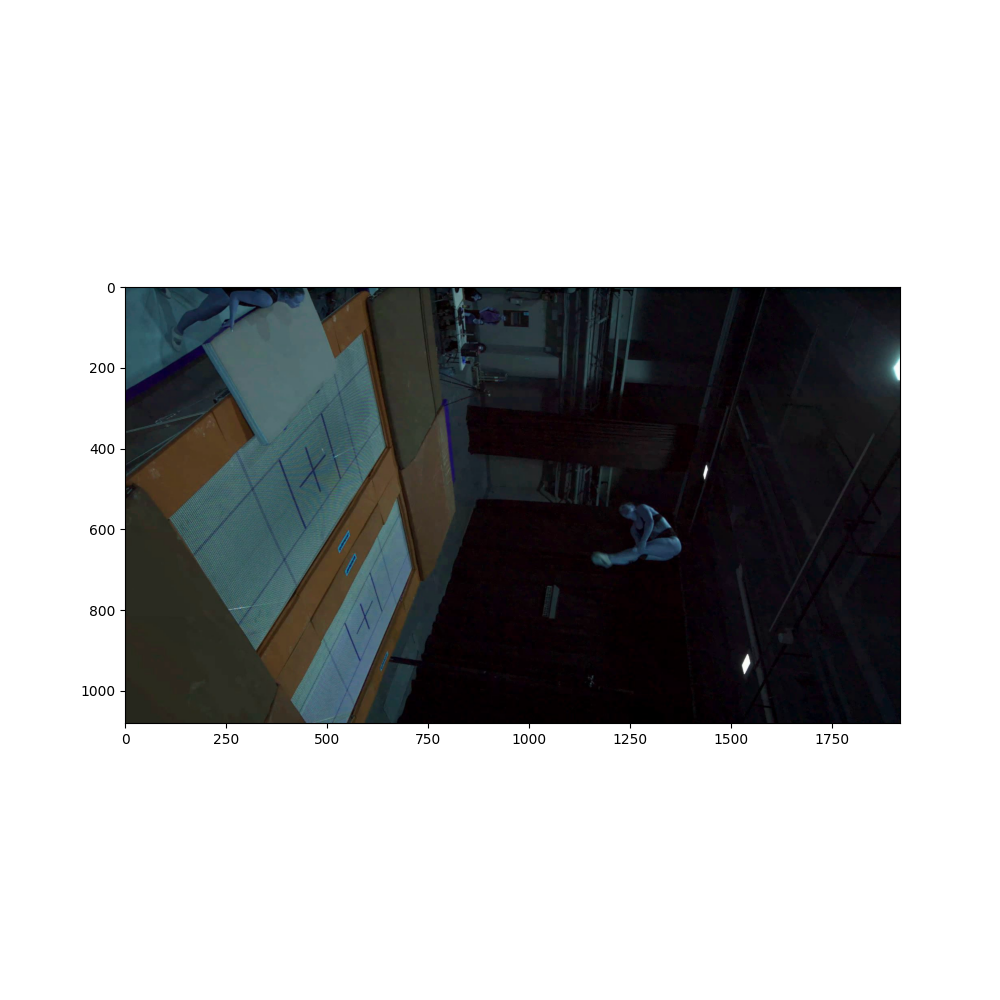

{'time': 229,
 'shot': 0,
 'frame_path': 'outputs//_DEMO/1_partie_0429_000-Camera1_M11139/img/000230.jpg',
 'tracked_ids': [1, 5],
 'tracked_bbox': [array([113.0636,   1.195 , 333.9255, 160.9713], dtype=float32),
  array([1158.5945,  529.0416,  221.3173,  163.0344], dtype=float32)],
 'tid': [1, 5],
 'bbox': [array([113.0636,   1.195 , 333.9255, 160.9713], dtype=float32),
  array([1158.5945,  529.0416,  221.3173,  163.0344], dtype=float32)],
 'tracked_time': [0, 0],
 'appe': [array([ 5.0502,  6.0068,  5.5822, ..., 10.0899, 10.1586,  6.8071],
        dtype=float32),
  array([ 6.3024,  6.1047,  6.2154, ..., 11.3142,  9.1238,  7.4335],
        dtype=float32)],
 'loca': [array([  0.2212,   0.247 ,   0.1996,   0.2314,   0.1788,   0.2353,
           0.1465,   0.231 ,   0.1376,   0.262 ,   0.1932,   0.2238,
           0.164 ,   0.2205,   0.158 ,   0.2489,   0.1377,   0.225 ,
           0.124 ,   0.2291,   0.0945,   0.2577,   0.0639,   0.2749,
           0.131 ,   0.2228,   0.1032,   0.2339,   

In [ ]:
plt.clf()
plt.cla()
plt.imshow(cv2.imread(os.path.join("/home/lea/trampo/4DHumans", frame_res["frame_path"])))
plt.show()


In [ ]:
bbox = frame_res["bbox"][1]


cam_crop2full(
    torch.from_numpy(frame_res["camera"][1]).unsqueeze(0),
    torch.from_numpy(frame_res["center"][1]).unsqueeze(0),
    torch.tensor(frame_res["scale"][1]).unsqueeze(0),
    torch.tensor(frame_res["size"][1]).unsqueeze(0),
    torch.tensor(K[0,0]).unsqueeze(0)
)

tensor([[ 11.7423, 184.4849,  44.2282]], dtype=torch.float64)

### Difference between 2D triangulation and 3D keypoints

['Camera3_M11141', 'Camera4_M11458']
1 detections
1 detections
Camera3_M11141 Camera4_M11458
[[439.8525 603.531  485.0228 622.5299 479.4742 629.004  435.1229 630.3331
  389.4083 611.2668 481.7679 649.4822 451.1976 704.7771 405.9554 747.2813
  472.9076 743.8362 458.259  758.1354 364.1521 779.9615 270.122  813.3202
  465.2608 767.8632 376.893  797.0032 283.6917 830.6172 446.1556 590.6644
  447.2541 593.9871 469.0252 587.7947 471.7149 595.5071 254.0562 801.2767
  258.443  821.5797 279.3925 844.4196 240.9691]
 [779.5809 240.5533 782.1452 264.2484 829.2938 283.415  813.6095 380.0731
  775.0503 474.5946 730.0345 489.6104 755.159  387.5458 793.9563 293.6342
  833.9717 398.5691 612.3519 436.9944 622.1666 481.8736 624.6323 485.0088
  641.8127 445.1873 695.0145 404.6005 741.7465 483.9822 623.0463 463.4163
  579.8895 482.0651 742.3531 483.9052 634.7342 496.5306 680.2567 460.1533
  607.5074 465.0871 574.7501 473.6692 802.228 ]]
[[848.5285 393.5828 860.5926 388.3657 867.4838 409.7718 891.467  423.4

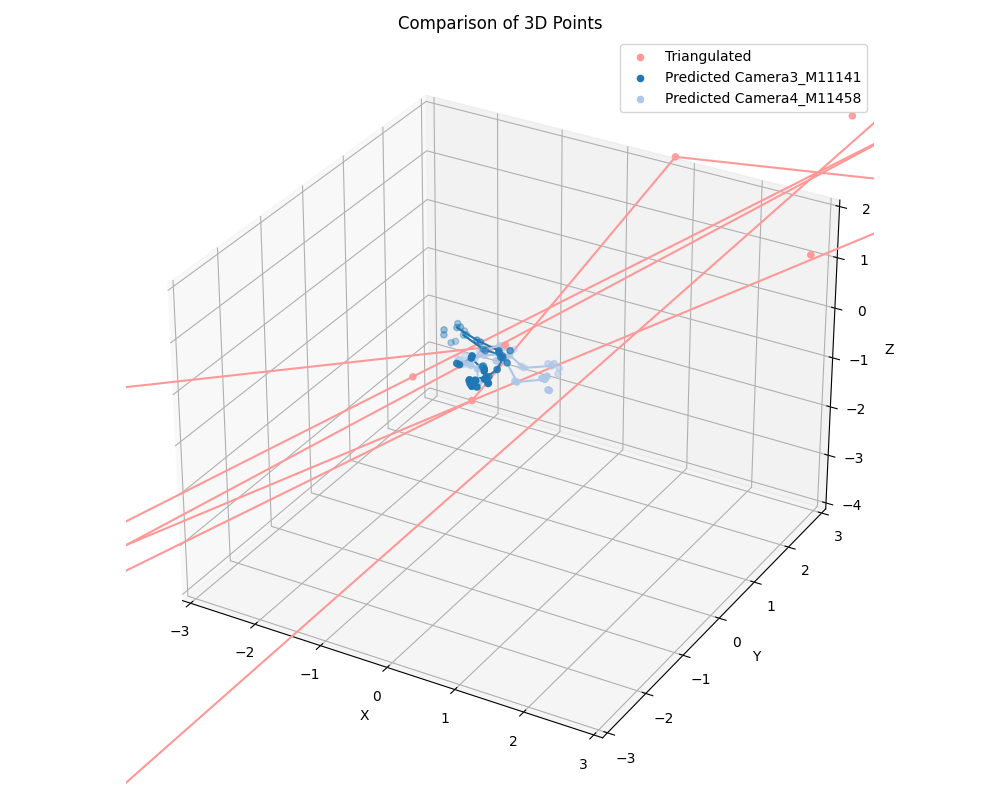

In [ ]:
%matplotlib widget
cmap = plt.get_cmap('tab20')
colors = [cmap(i / 20) for i in range(20)]

cameras = ['Camera1_M11139', 'Camera2_M11140', 'Camera3_M11141', 'Camera4_M11458', 'Camera5_M11459', 'Camera6_M11461', 'Camera7_M11462', 'Camera8_M11463']
sub_cam = cameras[2:4]

frame_idx = 124
routine = '1_partie_0429_000'
pts_2d = {cam:[] for cam in sub_cam}
pts_3d = deepcopy(pts_2d)

print(sub_cam)

for cam in sub_cam:
    filepath = f'/home/lea/trampo/4DHumans/outputs/results/demo_{routine}-{cam}.pkl'
    results = joblib.load(filepath)

    frame = f'outputs//_DEMO/{routine}-{cam}/img/{frame_idx:06d}.jpg' #['outputs//_DEMO/1_partie_0429-Camera1_M11139/img/000032.jpg']
    frame_res = results[frame]

    print(len(frame_res['tracked_ids']), 'detections')

    for d in range(len(frame_res['tracked_ids'])):
        joints_3d = frame_res['3d_joints'][d]
        cam_trans = frame_res['camera'][d]
        size = frame_res['size'][d]
        #pts_2d[cam] = frame_res['2d_joints'][0]
        pts_3d[cam].append(joints_3d)
        pts_2d[cam].append(project(joints_3d, cam_trans, size))

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

c = 7
for cam1 in sub_cam:
    for cam2 in sub_cam[sub_cam.index(cam1)+1:]:
        print(cam1, cam2)
        for pts1 in pts_2d[cam1]:
            pts1 = pts1.reshape((2,-1))
            for pts2 in pts_2d[cam2]:
                pts2 = pts2.reshape((2,-1))

                # Triangulate 3D points
                pts_triangulated = cv2.triangulatePoints(P_all[cameras.index(cam1)], P_all[cameras.index(cam2)], pts1, pts2)
                triangulated = pts_triangulated[:3] / np.clip(pts_triangulated[3], 1e-6, None)

                #triangulated = pts_triangulated[:3] / pts_triangulated[3] # convert from homogeneous
                triangulated = triangulated.reshape((-1,3))  # (N, 3)

                # Reproject triangulated points
                points_3d_h = np.hstack((triangulated, np.ones((triangulated.shape[0], 1)))).T  # 4xN
                pts1_reproj_h = P_all[cameras.index(cam1)] @ points_3d_h  # 3xN
                pts1_reproj = (pts1_reproj_h[:2] / pts1_reproj_h[2]).reshape((-1,2))  # Nx2

                pts2_reproj_h = P_all[cameras.index(cam2)] @ points_3d_h  # 3xN
                pts2_reproj = (pts2_reproj_h[:2] / pts2_reproj_h[2]).reshape((-1,2))  # Nx2
                
                # Plot triangulated 3D points (from OpenCV)
                print(triangulated[:5])
                ax.scatter(triangulated[:,0], triangulated[:,1], triangulated[:,2], color=colors[c], label='Triangulated')
                draw_skeleton(triangulated, colors[c], ax)
                c += 1

# Plot predicted 3D points (from file)
p = 0
for cam in sub_cam:
    for predicted in pts_3d[cam]:
        predicted = predicted.reshape((-1,3))  # make sure it's (3, N)
        ax.scatter(predicted[:,0], predicted[:,1], predicted[:,2], color=colors[p], label=f'Predicted {cam}')
        draw_skeleton(predicted, colors[p], ax)
        p += 1

# (Optional) Plot ground truth, if available
# ground_truth = np.array(...)  # shape (3, N)
# ax.scatter(ground_truth[0], ground_truth[1], ground_truth[2], c='b', label='Ground Truth', marker='s')

# Labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_zlim(-4, 2)
ax.legend()
ax.set_title('Comparison of 3D Points')

plt.tight_layout()
plt.show()


['Camera4_M11458', 'Camera5_M11459', 'Camera6_M11461', 'Camera7_M11462', 'Camera8_M11463']
1 detections
1 detections
1 detections
1 detections
1 detections


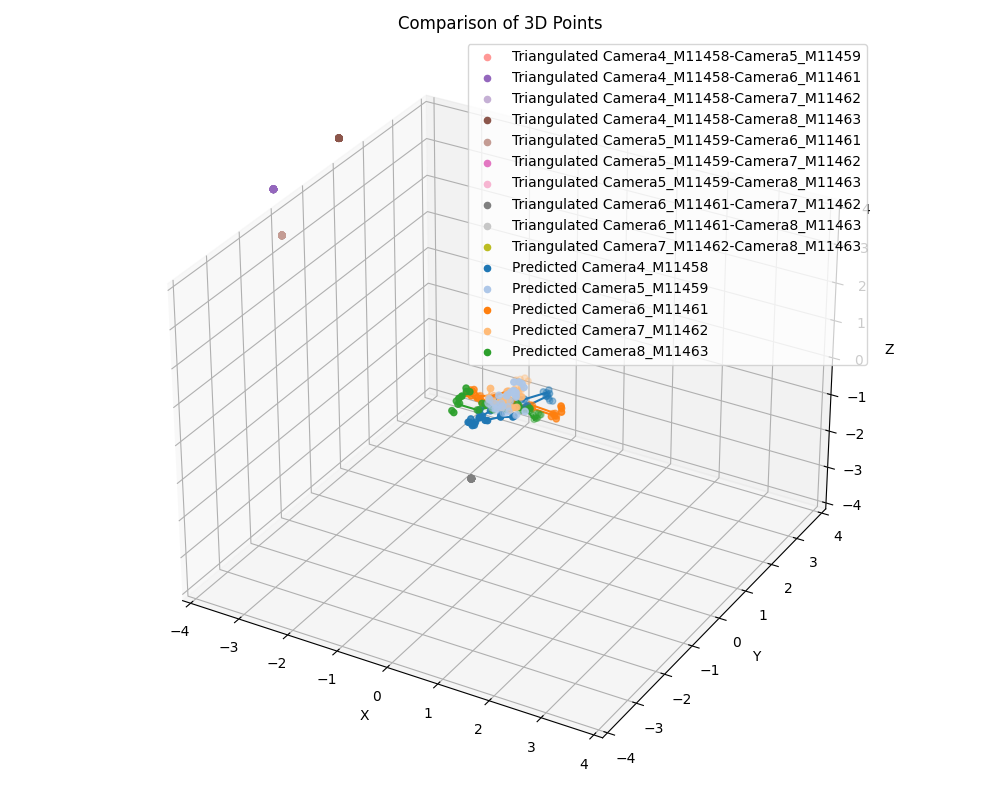

In [ ]:
frame_idx = 124
routine = '1_partie_0429_000'
pts_2d = {cam:[] for cam in sub_cam}
pts_3d = deepcopy(pts_2d)

print(sub_cam)

for cam in sub_cam:
    filepath = f'/home/lea/trampo/4DHumans/outputs/results/demo_{routine}-{cam}.pkl'
    results = joblib.load(filepath)

    frame = f'outputs//_DEMO/{routine}-{cam}/img/{frame_idx:06d}.jpg' #['outputs//_DEMO/1_partie_0429-Camera1_M11139/img/000032.jpg']
    frame_res = results[frame]

    print(len(frame_res['tracked_ids']), 'detections')

    for d in range(len(frame_res['tracked_ids'])):
        joints_3d = frame_res['3d_joints'][d]
        cam_trans = frame_res['camera'][d]
        size = frame_res['size'][d]
        #pts_2d[cam] = frame_res['2d_joints'][0]
        pts_3d[cam].append(joints_3d)
        pts_2d[cam].append(project(joints_3d, cam_trans, size))

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

c = 7  # color index for triangulated skeletons

# Build a dictionary of frame results for faster access
frame_results = {}
for cam in sub_cam:
    filepath = f'/home/lea/trampo/4DHumans/outputs/results/demo_{routine}-{cam}.pkl'
    results = joblib.load(filepath)
    frame_path = f'outputs//_DEMO/{routine}-{cam}/img/{frame_idx:06d}.jpg'
    frame_results[cam] = results[frame_path]

# Triangulate all camera pairs assuming person 0 is the same
for i, cam1 in enumerate(sub_cam):
    for cam2 in sub_cam[i+1:]:
        res1 = frame_results[cam1]
        res2 = frame_results[cam2]

        if len(res1['2d_joints']) == 0 or len(res2['2d_joints']) == 0:
            print(f"Skipping {cam1}-{cam2}: no detections")
            continue

        pts1 = res1['2d_joints'][0].reshape(2, -1)  # First detection
        pts2 = res2['2d_joints'][0].reshape(2, -1)

        P1 = P_all[cameras.index(cam1)]
        P2 = P_all[cameras.index(cam2)]

        pts_triangulated = cv2.triangulatePoints(P1, P2, pts1, pts2)
        triangulated = pts_triangulated[:3] / np.clip(pts_triangulated[3], 1e-6, None)
        triangulated = triangulated.T  # (N, 3)

        ax.scatter(triangulated[:,0], triangulated[:,1], triangulated[:,2], color=colors[c], label=f'Triangulated {cam1}-{cam2}')
        draw_skeleton(triangulated, colors[c], ax)
        c += 1

# Plot predicted 3D points (from file)
p = 0
for cam in sub_cam:
    for predicted in pts_3d[cam]:
        predicted = predicted.reshape((-1,3))  # make sure it's (3, N)
        ax.scatter(predicted[:,0], predicted[:,1], predicted[:,2], color=colors[p], label=f'Predicted {cam}')
        draw_skeleton(predicted, colors[p], ax)
        p += 1

# (Optional) Plot ground truth, if available
# ground_truth = np.array(...)  # shape (3, N)
# ax.scatter(ground_truth[0], ground_truth[1], ground_truth[2], c='b', label='Ground Truth', marker='s')

# Labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_zlim(-4, 4)
ax.legend()
ax.set_title('Comparison of 3D Points')

plt.tight_layout()
plt.show()



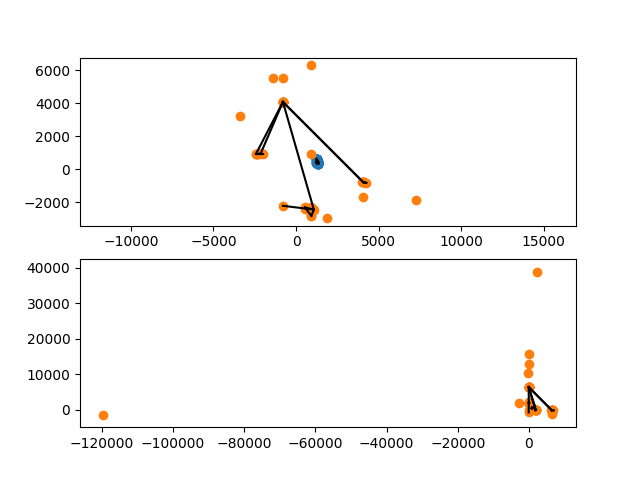

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1)

for pts in [pts_2d[sub_cam[-2]][0], pts1_reproj]:
    #pts = pts.reshape((-1, 2))
    ax1.scatter(pts[:,0], pts[:,1])
    draw_skeleton(pts, 'black', ax1)
    ax1.axis('equal')

for pts in [pts_2d[sub_cam[-1]][0], pts2_reproj]:
    #pts = pts.reshape((-1, 2))
    ax2.scatter(pts[:,0], pts[:,1])
    draw_skeleton(pts, 'black', ax2)
    ax2.axis('equal')

plt.show()